# Predizione degli FPS ottenibili con una configurazione di PC

**Programmazione di Applicazioni Data Intensive**  
Elaborato finale A.A. 2024/25  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena  

Kimi Osti  
`kimi.osti@studio.unibo.it`

<small>Tempo di esecuzione stimato: 1h30m</small>

Quando si asssembla un PC da Gaming, la decisione delle componenti da usare è sempre un processo molto critico.  
In particolare, una delle criticità risiede nell'enorme variabilità nelle specifiche dei giochi, che rende estremamente complesso stimare *a priori* le performance della configurazione scelta.  
Si propone quindi un modello che, a partire dalle specifiche di sistema, permetta di stimare il *framerate* ottenibile a seconda delle impostazioni grafiche (risoluzione e livello di qualità dei dettagli) del gioco scelto.  
L'obiettivo è quindi quello di dare agli utenti la possibilità di scegliere coscientemente le componenti del proprio PC da Gaming, massimizzando la user experience.

### Il Dataset

Per l'addestramento è stato usato il dataset [fps-in-video-games](https://www.openml.org/search?type=data&id=42737&sort=runs&status=active) disponibile su [OpenML](https://www.openml.org/). Il Dataset accorpa i dati raccolti da alcuni siti specializzati in benchmark e recensioni di componenti PC, fra cui [UserBenchmark](https://www.userbenchmark.com/) e [Tech Powerup](https://www.techpowerup.com/).  
Si sottolinea qui che il Dataset risale al 2020, e quindi alcuni dati possono essere considerati "obsoleti". Una delle principali sfide sarà quindi capire *quali* features usare per creare un modello abbastanza generico da non risentire dell'*età* dei dati.

In [1]:
import os
from urllib.request import urlretrieve

if not os.path.isfile("dataset.arff"):
    urlretrieve("https://www.openml.org/data/download/22044773/fps-in-video-games.arff", "dataset.arff")

Il Dataset è in formato ARFF (Attribute-Relationship File Format), un tipo di file che permette di salvare dati strutturati in modo simile a quello di un database.  
I dati contenuti in un file ARFF presentano un *header* con le informazioni sulla struttura dei dati stessi, seguito da un *corpo* con i dati effettivi.  
Per aprire file di questo tipo ci si appoggia sul modulo `scipy`, installandolo se necessario.

In [2]:
from importlib.metadata import version

try:
    from scipy.io import arff
    print("SciPy version " + version("scipy"))
except(ImportError, ModuleNotFoundError):
    ! pip install scipy
    from scipy.io import arff
    print("SciPy version " + version("scipy"))

SciPy version 1.13.1


A questo punto, estraggo i dati all'interno di una variabile `data` e le informazioni di intestazione in una variabile `meta`

In [3]:
data, meta = arff.loadarff("dataset.arff")

Stampo la variabile `data`, per verificarne il contenuto.

In [4]:
data

array([(b'Intel Core i7-920', 4.,  8., 133., 256., 1024.,  8., 0.000263, 2666., 20., b'0', 45., 130.,  731., 2933., b'AMD Radeon RX 480', b'GCN 4.0', 256000., 1120., 1266., b'PCIe 3.0 x16', 36., 0.000232, b'12', nan, 5834000., 256., 8000., b'GDDR5', b'2', b'4.6',  40510., 14., 32., b'6.4', 2304., 144., 182300., 5700., b'1.2.131', b'counterStrikeGlobalOffensive', 1080., b'low', b'userbenchmark',  70. ),
       (b'Intel Core i7-920', 4.,  8., 133., 256., 1024.,  8., 0.000263, 2666., 20., b'0', 45., 130.,  731., 2933., b'AMD Radeon RX 480', b'GCN 4.0', 256000., 1120., 1266., b'PCIe 3.0 x16', 36., 0.000232, b'12', nan, 5834000., 256., 8000., b'GDDR5', b'2', b'4.6',  40510., 14., 32., b'6.4', 2304., 144., 182300., 5700., b'1.2.131', b'counterStrikeGlobalOffensive', 1080., b'low', b'userbenchmark', 230. ),
       (b'Intel Core i5-4690', 4.,  4., 100., 256., 1024.,  6., 0.000177, 3400., 34., b'0', 22.,  84., 1400., 3800., b'NVIDIA GeForce GTX 1080 11Gbps', b'Pascal', 352300., 1607., 1733., b'

Per strutturare il contenuto di `data` e facilitarne il *preprocessing* e l'analisi, sfrutto la libreria `pandas`.  
Importo quindi il modulo, installandolo se necessario.

In [5]:
try:
    import pandas as pd
    print("Pandas version " + version("pandas"))
except(ImportError, ModuleNotFoundError):
    ! pip install pandas
    import pandas as pd
    print("Pandas version " + version("pandas"))

pd.options.display.max_columns = 50 # aumento il numero di colonne per evitare troncamenti dell'output in fase di analisi dei dati

Pandas version 2.2.2


Inizializzo quindi una variabile contenente il dataset strutturato, chiamata `data_structured` e ne stampo i primi elementi per verificare il contenuto.

In [6]:
data_structured = pd.DataFrame(data)
data_structured.head()

,CpuName,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuDieSize,CpuFrequency,CpuMultiplier,CpuMultiplierUnlocked,CpuProcessSize,CpuTDP,CpuNumberOfTransistors,CpuTurboClock,GpuName,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuNumberOfComputeUnits,GpuDieSize,GpuDirectX,GpuNumberOfExecutionUnits,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameName,GameResolution,GameSetting,Dataset,FPS
0,b'Intel Core i7-920',4.0,8.0,133.0,256.0,1024.0,8.0,0.000263,2666.0,20.0,b'0',45.0,130.0,731.0,2933.0,b'AMD Radeon RX 480',b'GCN 4.0',256000.0,1120.0,1266.0,b'PCIe 3.0 x16',36.0,0.000232,b'12',NaN,5834000.0,256.0,8000.0,b'GDDR5',b'2',b'4.6',40510.0,14.0,32.0,b'6.4',2304.0,144.0,182300.0,5700.0,b'1.2.131',b'counterStrikeGlobalOffensive',1080.0,b'low',b'userbenchmark',70.0
1,b'Intel Core i7-920',4.0,8.0,133.0,256.0,1024.0,8.0,0.000263,2666.0,20.0,b'0',45.0,130.0,731.0,2933.0,b'AMD Radeon RX 480',b'GCN 4.0',256000.0,1120.0,1266.0,b'PCIe 3.0 x16',36.0,0.000232,b'12',NaN,5834000.0,256.0,8000.0,b'GDDR5',b'2',b'4.6',40510.0,14.0,32.0,b'6.4',2304.0,144.0,182300.0,5700.0,b'1.2.131',b'counterStrikeGlobalOffensive',1080.0,b'low',b'userbenchmark',230.0
2,b'Intel Core i5-4690',4.0,4.0,100.0,256.0,1024.0,6.0,0.000177,3400.0,34.0,b'0',22.0,84.0,1400.0,3800.0,b'NVIDIA GeForce GTX 1080 11Gbps',b'Pascal',352300.0,1607.0,1733.0,b'PCIe 3.0 x16',NaN,0.000314,b'12',NaN,8873000.0,256.0,8000.0,b'GDDR5X',b'1.2',b'4.6',110900.0,16.0,64.0,b'6.4',2560.0,160.0,277300.0,7200.0,b'1.2.131',b'counterStrikeGlobalOffensive',1080.0,b'low',b'userbenchmark',250.0
3,b'Intel Core i5-4690',4.0,4.0,100.0,256.0,1024.0,6.0,0.000177,3400.0,34.0,b'0',22.0,84.0,1400.0,3800.0,b'NVIDIA GeForce GTX 1080 11Gbps',b'Pascal',352300.0,1607.0,1733.0,b'PCIe 3.0 x16',NaN,0.000314,b'12',NaN,8873000.0,256.0,8000.0,b'GDDR5X',b'1.2',b'4.6',110900.0,16.0,64.0,b'6.4',2560.0,160.0,277300.0,7200.0,b'1.2.131',b'counterStrikeGlobalOffensive',1080.0,b'low',b'userbenchmark',300.0
4,b'Intel Core i5-4690',4.0,4.0,100.0,256.0,1024.0,6.0,0.000177,3400.0,34.0,b'0',22.0,84.0,1400.0,3800.0,b'AMD Radeon R7 260X',b'GCN 2.0',104000.0,1100.0,1100.0,b'PCIe 3.0 x16',14.0,0.000160,b'12',NaN,1971000.0,128.0,2000.0,b'GDDR5',b'2',b'4.6',17600.0,28.0,16.0,b'6.3',896.0,56.0,61600.0,2080.0,b'1.2.131',b'counterStrikeGlobalOffensive',1080.0,b'low',b'userbenchmark',200.0


### Analisi delle Features

Si nota immediatamente che il Dataset ha 45 *features*.  
Se da un lato si può apprezzare la grande descrittività del Dataset, dall'altro l'elevatà dimensionalità può dare problemi di *performance* durante l'addestramento. Si cerca quindi da subito di individuare eventuali colonne *non significative* per limitare il problema senza perdita di informazione:
* `CpuName`: il nome della CPU non influenza in alcun modo le prestazioni della stessa.
* `GpuName`: analogamente per la GPU.
* `GameName`: una analisi più approfondita potrebbe mostrare che in diversi *generi* di gioco si registrano risultati *diversi*. È però da sottolineare che il *nome* del gioco senza altri dettagli è *poco significativo* rispetto alle prestazioni registrate, e mantenere i *nomi* dei giochi testati come *features* significherebbe non generalizzare il modello verso la predizione su *altri titoli*.
* `Dataset`: il Dataset di provenienza dei dati è poco rilevante rispetto alla predizione della variabile target.
* `CpuMultiplierUnlocked`: è un flag che rappresenta se il moltiplicatore di clock della CPU è *sbloccato* (e quindi modificabile dall'utente) o meno, ma non dà indicazioni sul valore effettivo del moltiplicatore, che è invece descritto dalla colonna `CpuMultiplier`. Il suo valore, sebbene sia correlato alla fascia di mercato della CPU (solitamente sono le CPU high-end ad avere il moltiplicatore sbloccato), non influenza direttamente la prestazione della CPU stessa.

In [7]:
data_structured = data_structured.drop(columns=["CpuName", "GpuName", "GameName", "Dataset", "CpuMultiplierUnlocked"])
data_structured.head()

,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuDieSize,CpuFrequency,CpuMultiplier,CpuProcessSize,CpuTDP,CpuNumberOfTransistors,CpuTurboClock,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuNumberOfComputeUnits,GpuDieSize,GpuDirectX,GpuNumberOfExecutionUnits,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameResolution,GameSetting,FPS
0,4.0,8.0,133.0,256.0,1024.0,8.0,0.000263,2666.0,20.0,45.0,130.0,731.0,2933.0,b'GCN 4.0',256000.0,1120.0,1266.0,b'PCIe 3.0 x16',36.0,0.000232,b'12',NaN,5834000.0,256.0,8000.0,b'GDDR5',b'2',b'4.6',40510.0,14.0,32.0,b'6.4',2304.0,144.0,182300.0,5700.0,b'1.2.131',1080.0,b'low',70.0
1,4.0,8.0,133.0,256.0,1024.0,8.0,0.000263,2666.0,20.0,45.0,130.0,731.0,2933.0,b'GCN 4.0',256000.0,1120.0,1266.0,b'PCIe 3.0 x16',36.0,0.000232,b'12',NaN,5834000.0,256.0,8000.0,b'GDDR5',b'2',b'4.6',40510.0,14.0,32.0,b'6.4',2304.0,144.0,182300.0,5700.0,b'1.2.131',1080.0,b'low',230.0
2,4.0,4.0,100.0,256.0,1024.0,6.0,0.000177,3400.0,34.0,22.0,84.0,1400.0,3800.0,b'Pascal',352300.0,1607.0,1733.0,b'PCIe 3.0 x16',NaN,0.000314,b'12',NaN,8873000.0,256.0,8000.0,b'GDDR5X',b'1.2',b'4.6',110900.0,16.0,64.0,b'6.4',2560.0,160.0,277300.0,7200.0,b'1.2.131',1080.0,b'low',250.0
3,4.0,4.0,100.0,256.0,1024.0,6.0,0.000177,3400.0,34.0,22.0,84.0,1400.0,3800.0,b'Pascal',352300.0,1607.0,1733.0,b'PCIe 3.0 x16',NaN,0.000314,b'12',NaN,8873000.0,256.0,8000.0,b'GDDR5X',b'1.2',b'4.6',110900.0,16.0,64.0,b'6.4',2560.0,160.0,277300.0,7200.0,b'1.2.131',1080.0,b'low',300.0
4,4.0,4.0,100.0,256.0,1024.0,6.0,0.000177,3400.0,34.0,22.0,84.0,1400.0,3800.0,b'GCN 2.0',104000.0,1100.0,1100.0,b'PCIe 3.0 x16',14.0,0.000160,b'12',NaN,1971000.0,128.0,2000.0,b'GDDR5',b'2',b'4.6',17600.0,28.0,16.0,b'6.3',896.0,56.0,61600.0,2080.0,b'1.2.131',1080.0,b'low',200.0


Il passo successivo è analizzare la *percentuale* di valori nulli per ogni colonna del dataset.  
Una colonna in cui buona parte dei dati siano nulli è infatti poco utile all'addestramento del modello di predizione.

In [8]:
mostly_null_columns = data_structured.columns[data_structured.isna().mean() > 0.4]
mostly_null_columns

Index(['CpuDieSize', 'CpuNumberOfTransistors', 'GpuNumberOfComputeUnits',
       'GpuNumberOfExecutionUnits'],
      dtype='object')

Usando come limite il 40% di valori nulli, riesco ad escludere altre 4 *features* non funzionali all'addestramento del modello di predizione.

In [9]:
data_structured = data_structured.drop(columns=mostly_null_columns)
data_structured.head()

,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuProcessSize,CpuTDP,CpuTurboClock,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuBus nterface,GpuDieSize,GpuDirectX,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuOpenCL,GpuOpenGL,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuShaderModel,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GpuVulkan,GameResolution,GameSetting,FPS
0,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,45.0,130.0,2933.0,b'GCN 4.0',256000.0,1120.0,1266.0,b'PCIe 3.0 x16',0.000232,b'12',5834000.0,256.0,8000.0,b'GDDR5',b'2',b'4.6',40510.0,14.0,32.0,b'6.4',2304.0,144.0,182300.0,5700.0,b'1.2.131',1080.0,b'low',70.0
1,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,45.0,130.0,2933.0,b'GCN 4.0',256000.0,1120.0,1266.0,b'PCIe 3.0 x16',0.000232,b'12',5834000.0,256.0,8000.0,b'GDDR5',b'2',b'4.6',40510.0,14.0,32.0,b'6.4',2304.0,144.0,182300.0,5700.0,b'1.2.131',1080.0,b'low',230.0
2,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,b'Pascal',352300.0,1607.0,1733.0,b'PCIe 3.0 x16',0.000314,b'12',8873000.0,256.0,8000.0,b'GDDR5X',b'1.2',b'4.6',110900.0,16.0,64.0,b'6.4',2560.0,160.0,277300.0,7200.0,b'1.2.131',1080.0,b'low',250.0
3,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,b'Pascal',352300.0,1607.0,1733.0,b'PCIe 3.0 x16',0.000314,b'12',8873000.0,256.0,8000.0,b'GDDR5X',b'1.2',b'4.6',110900.0,16.0,64.0,b'6.4',2560.0,160.0,277300.0,7200.0,b'1.2.131',1080.0,b'low',300.0
4,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,b'GCN 2.0',104000.0,1100.0,1100.0,b'PCIe 3.0 x16',0.000160,b'12',1971000.0,128.0,2000.0,b'GDDR5',b'2',b'4.6',17600.0,28.0,16.0,b'6.3',896.0,56.0,61600.0,2080.0,b'1.2.131',1080.0,b'low',200.0


Dal momento che il Dataset è stato prodotto nel 2020, e che alcune *features* rappresentano la *versione* di framework, API o dispositivi supportati dalle componenti studiate, esse possono essere rimosse.  
L'obiettivo è evitare bias eccessivi dovuti a specifiche proprie del periodo di registrazione del Dataset: attualmente, gli standard di versione delle *features* tracciate sono ormai obsoleti. In questo modo, si può rendere più astratta la formulazione del modello, migliorandone le capacità di *generalizzazione*.  
In particolare, si eliminano le *features* seguenti:
* `GpuOpenCL`
* `GpuShaderModel`
* `GpuVulkan`
* `GpuOpenGL`
* `GpuDirectX`
* `GpuBusInterface`

In [10]:
data_structured = data_structured.drop(columns=["GpuOpenCL", "GpuShaderModel", "GpuVulkan", "GpuOpenGL", "GpuDirectX", "GpuBus nterface"])
data_structured.head()

,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuProcessSize,CpuTDP,CpuTurboClock,GpuArchitecture,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuDieSize,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GameResolution,GameSetting,FPS
0,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,45.0,130.0,2933.0,b'GCN 4.0',256000.0,1120.0,1266.0,0.000232,5834000.0,256.0,8000.0,b'GDDR5',40510.0,14.0,32.0,2304.0,144.0,182300.0,5700.0,1080.0,b'low',70.0
1,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,45.0,130.0,2933.0,b'GCN 4.0',256000.0,1120.0,1266.0,0.000232,5834000.0,256.0,8000.0,b'GDDR5',40510.0,14.0,32.0,2304.0,144.0,182300.0,5700.0,1080.0,b'low',230.0
2,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,b'Pascal',352300.0,1607.0,1733.0,0.000314,8873000.0,256.0,8000.0,b'GDDR5X',110900.0,16.0,64.0,2560.0,160.0,277300.0,7200.0,1080.0,b'low',250.0
3,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,b'Pascal',352300.0,1607.0,1733.0,0.000314,8873000.0,256.0,8000.0,b'GDDR5X',110900.0,16.0,64.0,2560.0,160.0,277300.0,7200.0,1080.0,b'low',300.0
4,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,b'GCN 2.0',104000.0,1100.0,1100.0,0.000160,1971000.0,128.0,2000.0,b'GDDR5',17600.0,28.0,16.0,896.0,56.0,61600.0,2080.0,1080.0,b'low',200.0


Analogamente, si può ragionare per l'*architettura* della GPU, memorizzato nella *feature* `GpuArchitecture`. Riferendomi al [sito ufficiale NVIDIA](https://www.nvidia.com/en-us/technologies/) le architetture di GPU sono infatti in rapida evoluzione, e gli standard di mercato del 2020 non si possono più considerare attuali.

In [11]:
data_structured = data_structured.drop(columns="GpuArchitecture")
data_structured.head()

,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuProcessSize,CpuTDP,CpuTurboClock,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuDieSize,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuMemoryType,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GameResolution,GameSetting,FPS
0,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,45.0,130.0,2933.0,256000.0,1120.0,1266.0,0.000232,5834000.0,256.0,8000.0,b'GDDR5',40510.0,14.0,32.0,2304.0,144.0,182300.0,5700.0,1080.0,b'low',70.0
1,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,45.0,130.0,2933.0,256000.0,1120.0,1266.0,0.000232,5834000.0,256.0,8000.0,b'GDDR5',40510.0,14.0,32.0,2304.0,144.0,182300.0,5700.0,1080.0,b'low',230.0
2,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,352300.0,1607.0,1733.0,0.000314,8873000.0,256.0,8000.0,b'GDDR5X',110900.0,16.0,64.0,2560.0,160.0,277300.0,7200.0,1080.0,b'low',250.0
3,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,352300.0,1607.0,1733.0,0.000314,8873000.0,256.0,8000.0,b'GDDR5X',110900.0,16.0,64.0,2560.0,160.0,277300.0,7200.0,1080.0,b'low',300.0
4,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,104000.0,1100.0,1100.0,0.000160,1971000.0,128.0,2000.0,b'GDDR5',17600.0,28.0,16.0,896.0,56.0,61600.0,2080.0,1080.0,b'low',200.0


Lo stesso ragionamento si può applicare anche per la *feature* `GpuMemoryType`, dal momento che i modelli e i tipi di memoria lanciati sul mercato dai produttori sono in continua evoluzione.

In [12]:
data_structured = data_structured.drop(columns="GpuMemoryType")
data_structured.head()

,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuProcessSize,CpuTDP,CpuTurboClock,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuDieSize,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GameResolution,GameSetting,FPS
0,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,45.0,130.0,2933.0,256000.0,1120.0,1266.0,0.000232,5834000.0,256.0,8000.0,40510.0,14.0,32.0,2304.0,144.0,182300.0,5700.0,1080.0,b'low',70.0
1,4.0,8.0,133.0,256.0,1024.0,8.0,2666.0,20.0,45.0,130.0,2933.0,256000.0,1120.0,1266.0,0.000232,5834000.0,256.0,8000.0,40510.0,14.0,32.0,2304.0,144.0,182300.0,5700.0,1080.0,b'low',230.0
2,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,352300.0,1607.0,1733.0,0.000314,8873000.0,256.0,8000.0,110900.0,16.0,64.0,2560.0,160.0,277300.0,7200.0,1080.0,b'low',250.0
3,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,352300.0,1607.0,1733.0,0.000314,8873000.0,256.0,8000.0,110900.0,16.0,64.0,2560.0,160.0,277300.0,7200.0,1080.0,b'low',300.0
4,4.0,4.0,100.0,256.0,1024.0,6.0,3400.0,34.0,22.0,84.0,3800.0,104000.0,1100.0,1100.0,0.000160,1971000.0,128.0,2000.0,17600.0,28.0,16.0,896.0,56.0,61600.0,2080.0,1080.0,b'low',200.0


Si procede poi a convertire il *tipo* dell'unica variabile categorica rimasta nel Dataset, ovvero `GameSetting`.  
L'impostazione della qualità delle grafiche del gioco è infatti un discrimine importante nel calcolo del *framerate* previsto per la configurazione hardware installata.

In [13]:
data_structured["GameSetting"] = data_structured["GameSetting"].astype("category")

data_structured["GameSetting"].cat.categories # verifico la conversione al tipo categorico

Index([b'high', b'low', b'max', b'med'], dtype='object')

Dopo aver effettuato una prima analisi e scrematura delle *features non rilevanti*, si analizzano le *features* rimanenti.  
In particolare, si descrive il significato delle voci *meno autoesplicative* e si descrivono le unità di misura di alcune delle grandezze misurate.

In [14]:
data_structured.columns

Index(['CpuNumberOfCores', 'CpuNumberOfThreads', 'CpuBaseClock', 'CpuCacheL1',
       'CpuCacheL2', 'CpuCacheL3', 'CpuFrequency', 'CpuMultiplier',
       'CpuProcessSize', 'CpuTDP', 'CpuTurboClock', 'GpuBandwidth',
       'GpuBaseClock', 'GpuBoostClock', 'GpuDieSize', 'GpuFP32Performance',
       'GpuMemoryBus', 'GpuMemorySize', 'GpuPixelRate', 'GpuProcessSize',
       'GpuNumberOfROPs', 'GpuNumberOfShadingUnits', 'GpuNumberOfTMUs',
       'GpuTextureRate', 'GpuNumberOfTransistors', 'GameResolution',
       'GameSetting', 'FPS'],
      dtype='object')

* Tutte le misure di frequenza, indicate da *features* chiamate nella forma `*Frequency` o `*Clock`, sono misurate in MHz.
* `CpuCacheL1` e `CpuCacheL2` sono misurate in kB, `CpuCacheL3` è misurata in MB.
* `CpuProcessSize` e `GpuProcessSize`, misure base per le componenti dei chip della CPU e della GPU rispettivamente, sono misurate in nanometri.
* `CpuTDP` indica la quantità di calore dissipato dalla CPU, misurato in Watt.
* `GpuBandwidth` viene misurata in MB/s.
* `GpuDieSize` indica la dimensione del chip che ospita la GPU, in metri quadri.
* `GpuFP32Performance` indica le performance teoriche della GPU in *float32*, misurate in MFLOPs.
* `GpuMemoryBus` indica l'ampiezza in bit del bus di memoria della GPU.
* `GpuPixelRate` indica il pixel rate teorico in MPixel/s.
* `GpuNumberOfROPs` indica il numero di Raster Operation Pipelines (o Render Output Units) della GPU.
* `GpuNumberOfTMUs` indica il numero di Texture Mapping Units della GPU.
* `GpuTextureRate` indica il Texture Fill Rate in KTexels/s.
* `GameResolution` indica la risoluzione del gioco, definibile a runtime dall'utente modificando le impostazioni di gioco.
* `GameSetting` indica la raffinatezza del rendering video (per quanto riguarda texture, dettagli, particelle, ...) del gioco, può essere modificata a runtime dall'utente nelle impostazioni di gioco.
* `FPS` è la variabile *target*, il numero di frame al secondo a cui esegue il gioco.

Proseguo ora con un'analisi più approfondita delle *features*, per valutarne l'usabilità nel processo di addestramento.

Prima di tutto, visualizzo *media*, *deviazione standard*, *minimo*, *massimo* e *quartili* di tutti i dati numerici per avere una prima misura sull'usabilità dei dati raccolti.

In [15]:
data_structured.describe()

,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuProcessSize,CpuTDP,CpuTurboClock,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuDieSize,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GameResolution,FPS
count,425833.000000,425833.000000,425833.000000,425833.000000,425833.000000,420778.000000,425833.000000,425833.000000,425833.000000,425833.000000,425833.000000,4.103920e+05,425833.000000,425833.000000,414637.000000,4.257770e+05,410392.000000,410392.000000,425833.000000,425833.000000,425833.000000,425777.000000,425833.000000,425833.00000,414294.000000,425833.000000,425833.000000
mean,4.879042,7.893435,108.595719,348.152257,1989.470840,9.626468,3495.853123,33.422252,17.296017,81.365453,3998.218353,2.508934e+05,1283.728107,1443.065807,0.000289,5.281301e+06,247.725921,6034.502320,73316.627643,18.511745,48.479458,1749.803789,111.165349,166699.74474,5994.060998,1065.087957,138.545663
std,1.722288,3.838796,28.173990,168.379841,1805.837566,6.103498,445.981960,6.455594,7.029708,22.068487,490.780893,1.182169e+05,322.646809,299.773732,0.000125,3.041677e+06,214.591742,2707.272438,38603.080486,7.090753,21.607163,906.804881,55.468640,93522.36617,3076.806129,162.661232,87.818185
min,1.000000,1.000000,100.000000,64.000000,512.000000,2.000000,1500.000000,8.000000,7.000000,10.000000,1600.000000,4.256000e+03,100.000000,350.000000,0.000056,2.080000e+04,32.000000,128.000000,425.000000,7.000000,1.000000,8.000000,2.000000,850.00000,75.000000,720.000000,0.000000
25%,4.000000,4.000000,100.000000,256.000000,1024.000000,6.000000,3300.000000,32.000000,14.000000,65.000000,3700.000000,1.923000e+05,1050.000000,1178.000000,0.000200,2.378000e+06,192.000000,4000.000000,40510.000000,14.000000,32.000000,1152.000000,80.000000,87840.00000,4313.000000,1080.000000,80.000000
50%,4.000000,8.000000,100.000000,256.000000,1024.000000,8.000000,3500.000000,35.000000,14.000000,88.000000,4000.000000,2.400000e+05,1410.000000,1582.000000,0.000314,4.940000e+06,256.000000,6000.000000,82030.000000,16.000000,48.000000,1792.000000,120.000000,154400.00000,5700.000000,1080.000000,120.000000
75%,6.000000,12.000000,100.000000,384.000000,2048.000000,12.000000,3700.000000,37.000000,22.000000,95.000000,4350.000000,3.360000e+05,1506.000000,1709.000000,0.000332,6.463000e+06,256.000000,8000.000000,107700.000000,16.000000,64.000000,2304.000000,144.000000,202000.00000,7200.000000,1080.000000,180.000000
max,32.000000,64.000000,800.000000,3072.000000,18432.000000,64.000000,4700.000000,43.000000,90.000000,250.000000,5000.000000,1.024000e+06,1680.000000,1980.000000,0.000815,1.631000e+07,4096.000000,24000.000000,169900.000000,110.000000,96.000000,5120.000000,320.000000,509800.00000,21100.000000,1440.000000,1000.000000


Si notano subito le discrepanze fra gli *ordini di grandezza* dei dati: alcuni sono nell'ordine delle *unità*, altri arrivano fino all'ordine di grandezza dei *milioni*.  
Questa *dispersione* delle grandezze dei dati può causare *instabilità* nel processo di apprendimento, e verranno dettagliate più avanti delle strategie di *preprocessing* dei dati volte a mitigare il problema.

Si notano inoltre dei valori anomali come *minimo* e *massimo* per gli `FPS`.  
Infatti, da un lato avere 0 `FPS` significherebbe che il gioco non riesce a eseguire sulla configurazione inserita (e quindi la entry è comunque poco rilevante ai fini della regressione), e a maggior considerando il *primo quartile* a 80 `FPS`, le entry con tale valore possono rappresentare una criticità per gli algoritmi di regressione.  
Dall'altro lato, a fronte di un *terzo quartile* da 180 `FPS` (valore già elevato per una configurazione reale) si registra un massimo da 1000 `FPS`, valore impensabile in uno scenario di gioco relativamente "standard".

Osservando il Dataset, emergono immediatamente alcuni valori *anomali*.

Si prende in esame la *feature target*, ovvero `FPS`.  
Da un lato, si vede un valore minimo di 0 `FPS` a fronte di un *primo quartile* a 80. Mentre da un lato 80 `FPS` sono normalmente considerati un *buon risultato* in termini di esperienza utente, registrare 0 `FPS` significherebbe sostanzialmente non riuscire a eseguire il gioco sulla macchina testata. Proprio a fronte del *basso numero* di istanze a *basso framerate*, e della loro *poca significanza* ai fini dell'addestramento del modello di regressione (si dà per scontato che le configurazioni su cui svolgere previsioni rispettino i requisiti minimi di sistema delle applicazioni per cui si vogliono testare), si cerca di valutare l'impatto dello *scarto* delle entry da 0 `FPS`.

Si valuta quindi l'impatto in *cardinalità* sul dataset delle entry con `FPS` uguale a 0.

In [16]:
(data_structured["FPS"] == 0).mean()

0.004072018843067587

Dal momento che rappresentano meno dello 0.5% dell'intero Dataset, è possibile *scartare* le entry in cui viene registrato tale valore *anomalo*, senza realisticamente perdere contenuto informativo.

In [17]:
data_structured = data_structured[data_structured["FPS"] != 0]
data_structured.describe()

,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuProcessSize,CpuTDP,CpuTurboClock,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuDieSize,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GameResolution,FPS
count,424099.000000,424099.000000,424099.000000,424099.000000,424099.000000,419140.000000,424099.000000,424099.000000,424099.000000,424099.000000,424099.000000,4.087930e+05,424099.000000,424099.000000,412945.000000,4.240440e+05,408793.000000,408793.000000,424099.000000,424099.000000,424099.000000,424044.000000,424099.000000,424099.000000,412613.000000,424099.000000,424099.000000
mean,4.880985,7.897069,108.575564,348.291206,1989.971587,9.630212,3496.422616,33.430931,17.284676,81.384427,3999.054530,2.510801e+05,1284.297789,1443.675951,0.000289,5.286868e+06,247.864675,6039.469374,73393.859705,18.496783,48.523192,1751.445265,111.262493,166869.774718,5999.475303,1065.258725,139.112131
std,1.721660,3.838667,28.144222,168.386765,1805.842512,6.106258,445.870735,6.451097,7.017042,22.058958,490.283957,1.181449e+05,322.339312,299.326063,0.000125,3.040107e+06,214.818252,2705.216433,38571.699023,7.064957,21.587393,906.247137,55.437453,93474.704153,3074.553755,162.515149,87.548633
min,1.000000,1.000000,100.000000,64.000000,512.000000,2.000000,1500.000000,8.000000,7.000000,10.000000,1600.000000,4.256000e+03,100.000000,350.000000,0.000056,2.080000e+04,32.000000,128.000000,425.000000,7.000000,1.000000,8.000000,2.000000,850.000000,75.000000,720.000000,10.000000
25%,4.000000,4.000000,100.000000,256.000000,1024.000000,6.000000,3300.000000,32.000000,14.000000,65.000000,3700.000000,1.923000e+05,1050.000000,1178.000000,0.000200,2.378000e+06,192.000000,4000.000000,40510.000000,14.000000,32.000000,1152.000000,80.000000,87840.000000,4313.000000,1080.000000,80.000000
50%,4.000000,8.000000,100.000000,256.000000,1024.000000,8.000000,3500.000000,35.000000,14.000000,88.000000,4000.000000,2.400000e+05,1410.000000,1582.000000,0.000314,4.940000e+06,256.000000,6000.000000,82030.000000,16.000000,48.000000,1792.000000,120.000000,155600.000000,5700.000000,1080.000000,120.000000
75%,6.000000,12.000000,100.000000,384.000000,2048.000000,12.000000,3700.000000,37.000000,22.000000,95.000000,4350.000000,3.360000e+05,1506.000000,1709.000000,0.000334,6.463000e+06,256.000000,8000.000000,107700.000000,16.000000,64.000000,2304.000000,144.000000,202000.000000,7200.000000,1080.000000,180.000000
max,32.000000,64.000000,800.000000,3072.000000,18432.000000,64.000000,4700.000000,43.000000,90.000000,250.000000,5000.000000,1.024000e+06,1680.000000,1980.000000,0.000815,1.631000e+07,4096.000000,24000.000000,169900.000000,110.000000,96.000000,5120.000000,320.000000,509800.000000,21100.000000,1440.000000,1000.000000


Si osserva poi, sempre per la *feature target*, a fronte di un *terzo quartile* a 180 `FPS`, un massimo a 1000 `FPS`.  
Mentre 180 `FPS` sono un valore ottenibile solamente con macchine di *altissima fascia*, 1000 `FPS` sono un numero sostanzialmente *insosservabile* su qualsiasi macchina in commercio, indipendentemente dal gioco testato.  
Si considerano quindi i valori *eccessivamente alti* di `FPS` come valori *anomali*, e si procede ad analizzare l'impatto sul Dataset dello *scarto* delle entry con *framerate* superiore a 350 (già un valore *estremamente alto*).

In [18]:
(data_structured["FPS"] > 350).mean()

0.016892282226555592

Circa l'1.7% delle entry riportano un valore oltre al *threshold* stabilito. Con l'obiettivo di stabilizzare l'apprendimento e la regressione, è possibile *rimuovere* le entry interessate, senza presumibilmente andare incontro a una perdita di *contenuto informativo*.

In [19]:
data_structured = data_structured[data_structured["FPS"] <= 350]
data_structured.describe()

,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuProcessSize,CpuTDP,CpuTurboClock,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuDieSize,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GameResolution,FPS
count,416935.000000,416935.000000,416935.000000,416935.000000,416935.00000,411984.000000,416935.000000,416935.000000,416935.000000,416935.000000,416935.000000,4.016310e+05,416935.000000,416935.000000,405781.000000,4.168800e+05,401631.000000,401631.000000,416935.000000,416935.000000,416935.000000,416880.000000,416935.000000,416935.000000,405449.000000,416935.000000,416935.000000
mean,4.872421,7.868816,108.706851,347.851094,1994.97088,9.602111,3492.489887,33.368167,17.330440,81.258316,3992.571334,2.498038e+05,1281.724108,1441.206574,0.000288,5.252557e+06,247.518902,6014.152483,72957.844573,18.528819,48.294792,1742.394147,110.719685,165818.556581,5965.135003,1064.685958,133.722819
std,1.721936,3.835436,28.338487,168.546359,1813.63277,6.099856,446.484400,6.468958,7.050917,22.151869,489.629640,1.177796e+05,323.543716,300.031378,0.000125,3.032818e+06,215.726542,2706.915627,38580.958713,7.091943,21.599499,904.905680,55.348453,93239.616948,3058.142900,162.934044,77.005839
min,1.000000,1.000000,100.000000,64.000000,512.00000,2.000000,1500.000000,8.000000,7.000000,10.000000,1600.000000,4.256000e+03,100.000000,350.000000,0.000056,2.080000e+04,32.000000,128.000000,425.000000,7.000000,1.000000,8.000000,2.000000,850.000000,75.000000,720.000000,10.000000
25%,4.000000,4.000000,100.000000,256.000000,1024.00000,6.000000,3300.000000,32.000000,14.000000,65.000000,3700.000000,1.923000e+05,1050.000000,1178.000000,0.000200,2.332000e+06,192.000000,4000.000000,40510.000000,14.000000,32.000000,1024.000000,80.000000,87840.000000,3540.000000,1080.000000,80.000000
50%,4.000000,8.000000,100.000000,256.000000,1024.00000,8.000000,3500.000000,35.000000,14.000000,88.000000,4000.000000,2.244000e+05,1410.000000,1582.000000,0.000314,4.849000e+06,256.000000,6000.000000,82030.000000,16.000000,48.000000,1792.000000,120.000000,154400.000000,5700.000000,1080.000000,120.000000
75%,6.000000,12.000000,100.000000,384.000000,2048.00000,12.000000,3700.000000,37.000000,22.000000,95.000000,4300.000000,3.360000e+05,1506.000000,1709.000000,0.000314,6.463000e+06,256.000000,8000.000000,107700.000000,16.000000,64.000000,2304.000000,144.000000,202000.000000,7200.000000,1080.000000,172.600000
max,32.000000,64.000000,800.000000,3072.000000,18432.00000,64.000000,4700.000000,43.000000,90.000000,250.000000,5000.000000,1.024000e+06,1680.000000,1980.000000,0.000815,1.631000e+07,4096.000000,24000.000000,169900.000000,110.000000,96.000000,5120.000000,320.000000,509800.000000,21100.000000,1440.000000,350.000000


Si nota fra l'altro come il *terzo quartile* degli `FPS`, a fronte di una diminuzione del massimo da 1000 a 350 (quasi ridotto a un terzo del valore iniziale), sia calato solo di 8 unità rispetto al valore precedentemente registrato (172 a fronte di un valore iniziale di 180), a riprova del basso impatto informativo della *rimozione* delle entry applicate.  
Si sottolinea inoltre come il minimo valore di `FPS` sia 10, valore più significativo seppure ancora *basso* se rapportato al *primo quartile*, rimasto invariato dopo le modifiche applicate.


Si passa poi ad analizzare il valore di *deviazione standard* delle *features*, nella riga `std`. Si isolano quindi le *features numeriche* con una *deviazione standard* maggiore o uguale all'80% della loro *media*.  
Si applica questa misura come *semplificazione*, dal momento che tutte le *features* hanno solo valori positivi.

Per isolare le *features numeriche*, si può sfruttare il *tipo* con cui i dati sono salvati in memoria.

In [20]:
data_structured.select_dtypes(exclude="category").dtypes

CpuNumberOfCores           float64
CpuNumberOfThreads         float64
CpuBaseClock               float64
CpuCacheL1                 float64
CpuCacheL2                 float64
CpuCacheL3                 float64
CpuFrequency               float64
CpuMultiplier              float64
CpuProcessSize             float64
CpuTDP                     float64
CpuTurboClock              float64
GpuBandwidth               float64
GpuBaseClock               float64
GpuBoostClock              float64
GpuDieSize                 float64
GpuFP32Performance         float64
GpuMemoryBus               float64
GpuMemorySize              float64
GpuPixelRate               float64
GpuProcessSize             float64
GpuNumberOfROPs            float64
GpuNumberOfShadingUnits    float64
GpuNumberOfTMUs            float64
GpuTextureRate             float64
GpuNumberOfTransistors     float64
GameResolution             float64
FPS                        float64
dtype: object

Dopo aver verificato l'*uniformità* di tipo delle *features numeriche*, procedo a isolarle sfruttando proprio il *tipo* come selettore.

In [21]:
data_structured.select_dtypes("float64").loc[
    :,
    (data_structured.select_dtypes("float64").std() >= data_structured.select_dtypes("float64").mean() * 0.8).values
].describe()

,CpuCacheL2,GpuMemoryBus
count,416935.00000,401631.000000
mean,1994.97088,247.518902
std,1813.63277,215.726542
min,512.00000,32.000000
25%,1024.00000,192.000000
50%,1024.00000,256.000000
75%,2048.00000,256.000000
max,18432.00000,4096.000000


Di tali *features* si cerca di capire la *distribuzione* sfruttando grafici, e successivamente si analizzeranno i loro *indici di correlazione* con altre *features* per valutare se sia possibile *rimuoverle* dal Dataset.  
Infatti, un valore di *deviazione standard* molto elevato è indice di una distribuzione dei valori *molto ampia*, che provoca *errori elevati* nelle funzioni di regressione che approssimano i dati.  
Verificare una *forte correlazione* fra tali *features* e altre nel Dataset permetterebbe di *eliminarle* e arginare il problema della *distribuzione* senza perdere espressività dei dati. 

Per visualizzare i *grafici* delle *features* individuate, si sfrutta la libreria `Matplotlib`.  
Si importa quindi il modulo corrispondente, installandolo se necessario.

In [22]:
try:
    import matplotlib.pyplot as plt
except(ImportError, ModuleNotFoundError):
    ! pip install matplotlib
    import matplotlib.pyplot as plt

print("Matplotlib version " + version("matplotlib"))

Matplotlib version 3.9.2


Si lavora ora sulla *feature* `CpuCacheL2`, che rappresenta la cache di livello 2 della CPU misurata in kB.  
Se ne visualizza un grafico di dispersione.

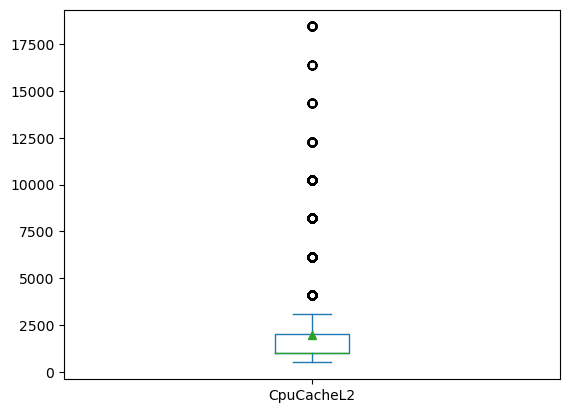

In [23]:
l2_cache = data_structured["CpuCacheL2"]

l2_cache.plot.box(showmeans=True);

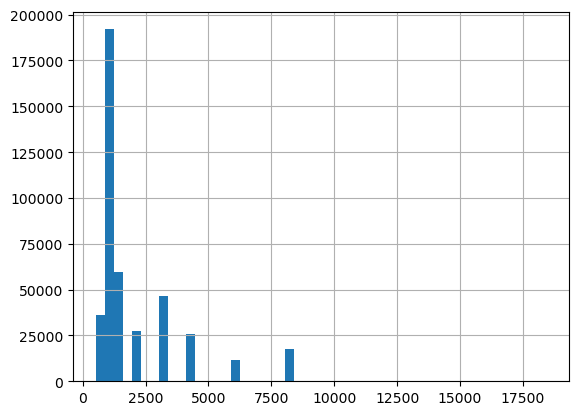

In [24]:
l2_cache.hist(bins=50);

Si nota da entrambi i grafici come la gran parte dei valori sia concentrata fra 0 e 2000 indicativamente, con la *media* molto vicina al *terzo quartile*.  
Ciò perché sono presenti pochi valori *molto grandi* (il *massimo* è circa un ordine di grandezza in più rispetto alla *media*) che influenzano pesantemente la distribuzione.

Valuto quindi la *correlazione* della *feature* considerata rispetto ad altre del Dataset, per esplorare la possibilità di *scartare* interamente la *feature*, se strettamente correlata ad altre (e quindi ad essa approssimabile a meno di un fattore moltiplicativo, che verrebbe poi comunque appreso in fase di addestramento dei modelli).

Si introduce quindi il concetto di *coefficiente di correlazione*, che indica quanto due misure siano fra loro *correlate*, ovvero quanto al variare di una corrisponde il variare dell'altra.  
Per farlo si usa `NumPy`, libreria ottimizzata per il calcolo algebrico. Si importa il modulo corrispondente, installandolo se necessario.

In [25]:
try:
    import numpy as np
except(ImportError, ModuleNotFoundError):
    ! pip install numpy
    import numpy as np

print("NumPy version " + version("numpy"))

NumPy version 1.26.4


Si definisce poi la funzione `correl_coef`, in grado di calcolare il coefficiente di correlazione date due colonne del Dataset.

In [26]:
def correl_coef(a, b):
    return np.mean((a - np.mean(a)) * (b - np.mean(b))) / (np.std(a) * np.std(b))

Si calcola quindi il coefficiente di correlazione di `CpuCacheL2` con `CpuCacheL1` e `CpuCacheL3` rispettivamente, *features* che rappresentano grandezze affini.

In [27]:
correl_coef(l2_cache, data_structured["CpuCacheL1"])

0.537957845753066

In [28]:
correl_coef(l2_cache, data_structured["CpuCacheL3"])

0.38868016802187594

Dai risultati, non emerge un *coefficiente di correlazione* soddisfacente per nessuno dei due valori.

Pertanto, non è possibile *scartare* la feature, a meno di perdere espressività del Dataset.

Si può però valutare l'impatto dell'*eliminazione* di alcune entry *problematiche* per il dato di *dispersione*.  
Per farlo, si cerca di valutare l'impatto sul Dataset dello scarto delle entry con valore maggiore o uguale al *quadruplo della media*.

In [29]:
(l2_cache >= l2_cache.mean() * 4).mean()

0.043551153057431014

Scartare tali entry significherebbe *rimuovere* il 4.36% delle entry del Dataset. Dal momento che è un numero abbastanza *elevato* di entry da rimuovere, si cerca di valutare l'impatto dell'operazione per valutarne gli eventuali *benefici*.

Si valuta quindi l'impatto sul dato di *dispersione* della rimozione degli outliers.  
Prima si visualizzano le *statistiche base* della *feature senza outliers*. Dopodiché si paragona il rapporto fra *deviazione standard* e *media*, con o senza *outliers* nel Dataset.

In [30]:
is_l2_cache_outlier = l2_cache >= (l2_cache.mean() * 4)
l2_cache[~is_l2_cache_outlier].describe()

count    398777.000000
mean       1707.694235
std        1230.063091
min         512.000000
25%        1024.000000
50%        1024.000000
75%        2048.000000
max        6144.000000
Name: CpuCacheL2, dtype: float64

In [31]:
print(f"Con outliers: {l2_cache.std() / l2_cache.mean()}")
print(f"Senza outliers: {l2_cache[~is_l2_cache_outlier].std() / l2_cache[~is_l2_cache_outlier].mean()}")

Con outliers: 0.909102377557677
Senza outliers: 0.7203064022113487


Si osserva che, seppur a fronte di uno scarto di una percentuale *relativamente elevata* di entry, il valore di *dispersione* del dato migliora *visibilmente*.  
Dall'altro lato però, si può contare su un Dataset *molto grande* (circa 450000 istanze), e pertanto si può valutare che il *valore informativo* del Dataset stesso rimanga elevato anche a fronte di uno *scarto* di una percentuale come quella del caso in esame.  
Si decide quindi di applicare la *rimozione* delle entry.

In [32]:
data_structured = data_structured[~is_l2_cache_outlier]

Si analizza ora la *feature* `GpuMemoryBus`.

In [33]:
gpu_membus = data_structured["GpuMemoryBus"]

Se ne visualizzano, come in precedenza, i *grafici di dispersione*.

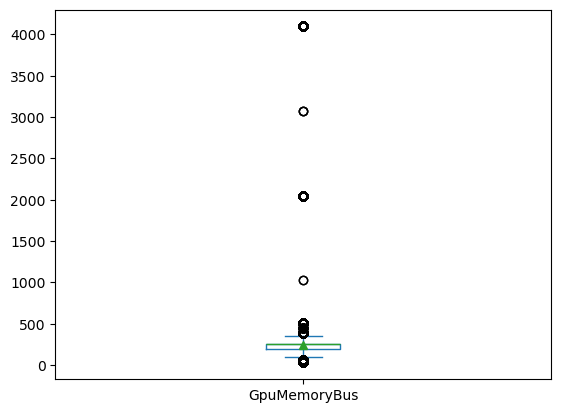

In [34]:
gpu_membus.plot.box(showmeans=True);

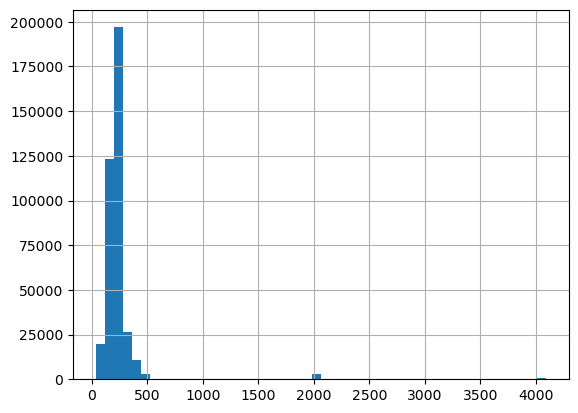

In [35]:
gpu_membus.hist(bins=50);

Si vede anche qui una distribuzione molto estrema, come nel caso di `CpuCacheL2`.  
Per mitigare il problema, si valuta nuovamente l'impatto della *rimozione* degli *outlier*, valori estremi che influenzano negativamente la distribuzione. Se ne calcola quindi la quantità, ponendo come *threshold* il *quintuplo della media*.

In [36]:
(gpu_membus >= gpu_membus.mean() * 5).mean()

0.008014504347041079

Ponendo tale valore come *threshold*, si perdono lo 0.78% delle entry del Dataset. Si procede quindi a verificare l'impatto della *rimozione degli outlier* sulla qualità della distribuzione della *feature*.  
Per farlo, si procede analogamente a come visto per `CpuCacheL2`

In [37]:
is_gpu_membus_outlier = gpu_membus >= (gpu_membus.mean() * 5)
gpu_membus[~is_gpu_membus_outlier].describe()

count    380281.000000
mean        229.740513
std          75.011896
min          32.000000
25%         192.000000
50%         256.000000
75%         256.000000
max        1024.000000
Name: GpuMemoryBus, dtype: float64

In [38]:
print(f"Con outliers: {gpu_membus.std() / gpu_membus.mean()}")
print(f"Senza outliers: {gpu_membus[~is_gpu_membus_outlier].std() / gpu_membus[~is_gpu_membus_outlier].mean()}")

Con outliers: 0.8711190310699035
Senza outliers: 0.32650704295063476


Rimuovendo quindi lo 0.78% delle entry del Dataset, il dato di *dispersione* per questa *feature* migliora *notevolmente*.  
Si procede quindi a *rimuovere* gli *outliers*, e poi si verifica per completezza che l'operazione non abbia avuto *side-effects* indesiderati.

In [39]:
data_structured = data_structured[~is_gpu_membus_outlier]

data_structured.select_dtypes("float64").loc[
    :,
    (data_structured.select_dtypes("float64").std() >= data_structured.select_dtypes("float64").mean() * 0.8).values
]

""
0
1
2
3
4
...
425828
425829
425830
425831


Dopo aver verificato che non vengono peggiorati altri dati di dispersione rimuovendo gli *outliers* per i dati di `CpuCacheL2` e `GpuMemoryBus`, si procede alla *preparazione* delle features per l'addestramento dei modelli.

### Preparazione delle features

Dopo una fase preliminare di *analisi* delle *features* del Dataset, che ne ha permesso una semplificazione e una rimodellazione per mitigare l'*instabilità*, si può procedere alla *preparazione* delle *features* stesse per adattarle alla forma richiesta per l'addestramento del modello di regressione.

In primo luogo, si devono valutare le strategie di gestione dei valori *nulli*.  
Nella fase precedente, si sono rimosse alcune *features* sulla base della quantità di valori *nulli* che contenevano. Ora si passa invece a gestire quelle *features* che hanno valori *nulli*, ma non in una concentrazione valida a giustificare l'eliminazione delle *features*.  
Le entry con valore nullo vanno infatti *rimosse* o popolate con valori *fittizi*, dal momento che i modelli di regressione non riescono a lavorare con valori *nulli*.

In [40]:
data_structured[data_structured.columns[data_structured.isna().sum() != 0]].isna().sum()

CpuCacheL3                  4950
GpuBandwidth               15300
GpuDieSize                 11154
GpuFP32Performance            55
GpuMemoryBus               15300
GpuMemorySize              15300
GpuNumberOfShadingUnits       55
GpuNumberOfTransistors     11483
dtype: int64

Con questa operazione preliminare, si sono *isolate* le *features* con valori *nulli*.  
Si sceglie di seguire la strategia implementata dalla classe `Imputer` di `scikit-learn`, applicando però qui lo stesso procedimento con funzioni *built-in* di `Pandas`.  
Si inserisce quindi, al posto dei valori *nulli*, il valore *medio* della *feature* corrispondente. Questo approccio è *significativo* e *semanticamente corretto* se si pensa di star lavorando con *features numeriche*.

In [41]:
null_value_columns = data_structured.columns[data_structured.isna().sum() != 0]
data_structured[null_value_columns] = data_structured[null_value_columns].fillna(data_structured[null_value_columns].mean())

data_structured[data_structured.columns[data_structured.isna().sum() != 0]].columns # verifico l'assenza di colonne con valori nulli

Index([], dtype='object')

Dopo aver risolto *definitivamente* il problema dei valori *nulli*, nel Dataset si può isolare la *feature target* (ovvero l'obiettivo della regressione) dalle altre *features*.  
Salvo in `X` le *features* di input, mentre salvo in `y` i valori target.

In [42]:
y = data_structured["FPS"]
X = data_structured.drop(columns="FPS")

In [43]:
X.shape

(395581, 27)

In [44]:
y.shape

(395581,)

A questo punto, si possono applicare due tecniche per la suddivisione dei dati di *addestramento* e *validazione*:
* `Hold-Out`: i dati vengono divisi in due sottoinsiemi secondo una proporzione decisa a priori. In questo caso, il 60% delle istanze saranno *training set* e il 40% *validation set*.
* `K-Fold`: metodo usato per la *cross-validation*, che prevede di suddividere equamente i dati in K sottoinsiemi, per poi usarli alternativamente come *training set* o *validation set* per l'addestramento di più modelli.

Per entrambe le suddivisioni si sfrutta la libreria `scikit-learn`, di cui si importano i moduli eventualmente installandoli.

In [45]:
try:
    import sklearn
except(ImportError, ModuleNotFoundError):
    ! pip install sklearn

print("scikit-learn version " + sklearn.__version__)

scikit-learn version 1.5.1


Si procede ora a creare i sottoinsiemi di training e validazione secondo il metodo `Hold-Out`.

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.4,
    shuffle=True,
    random_state=42
)

In [47]:
X_train.head()

,CpuNumberOfCores,CpuNumberOfThreads,CpuBaseClock,CpuCacheL1,CpuCacheL2,CpuCacheL3,CpuFrequency,CpuMultiplier,CpuProcessSize,CpuTDP,CpuTurboClock,GpuBandwidth,GpuBaseClock,GpuBoostClock,GpuDieSize,GpuFP32Performance,GpuMemoryBus,GpuMemorySize,GpuPixelRate,GpuProcessSize,GpuNumberOfROPs,GpuNumberOfShadingUnits,GpuNumberOfTMUs,GpuTextureRate,GpuNumberOfTransistors,GameResolution,GameSetting
147958,2.0,2.0,100.0,128.0,512.0,2.0,2400.0,24.0,22.0,35.0,2400.0,249782.819625,200.0,1100.0,0.000181,704000.0,229.740513,6044.643314,4400.0,22.0,4.0,320.0,40.0,44000.0,1300.0,720.0,b'low'
196344,4.0,4.0,100.0,256.0,1024.0,6.0,3300.0,33.0,32.0,95.0,3700.0,112100.000000,1291.0,1392.0,0.000132,2138000.0,128.000000,4000.000000,44540.0,14.0,32.0,768.0,48.0,66820.0,3300.0,1080.0,b'high'
29800,2.0,4.0,100.0,128.0,512.0,4.0,3700.0,37.0,14.0,51.0,3700.0,216700.000000,1506.0,1709.0,0.000200,4375000.0,192.000000,6000.000000,82030.0,16.0,48.0,1280.0,80.0,136700.0,4400.0,1080.0,b'low'
361993,6.0,12.0,100.0,576.0,3072.0,16.0,3400.0,34.0,12.0,65.0,3900.0,216700.000000,1506.0,1709.0,0.000200,4375000.0,192.000000,6000.000000,82030.0,16.0,48.0,1280.0,80.0,136700.0,4400.0,1080.0,b'med'
318151,6.0,12.0,100.0,576.0,3072.0,16.0,3200.0,32.0,14.0,65.0,3600.0,216700.000000,1506.0,1709.0,0.000200,4375000.0,192.000000,6000.000000,82030.0,16.0,48.0,1280.0,80.0,136700.0,4400.0,1080.0,b'max'


In [48]:
y_train.head()

147958     50.0
196344    270.0
29800     160.0
361993    140.0
318151     70.0
Name: FPS, dtype: float64

Dopodiché, parallelamente, si crea l'oggetto che mantiene le informazioni relative alla suddivisione secondo il metodo `K-Fold`.  
Vista la grandezza del Dataset, si creano due oggetti, a 5 e 7 fold rispettivamente. Verranno poi discusse le performance di entrambi.

Entrambi i metodi saranno usati più avanti in fase di addestramento dei modelli, comparandone i risultati.

In [49]:
from sklearn.model_selection import KFold

k_fold_5 = KFold(5, random_state=42, shuffle=True)
k_fold_7 = KFold(7, random_state=42, shuffle=True)

Dopo aver affrontato la suddivisione dei dati in *dati di training* e *dati di valutazione*, si deve affrontare il problema delle *features categoriche*. Esse infatti non possono essere direttamente processate da un *modello di regressione*, che gestisce solo dati *numerici*.

Per risolvere il problema, si può usare la tecnica del *one-hot encoding*: al valore categorico viene sostituito un array di valori con un indice per ogni categoria, che fa quindi corrispondere ad ogni indice un valore 0 o 1 che indica se il dato corrispondente appartiene o meno alla categoria corrispondente all'indice.  
L'implementazione di tale tecnica è fornita dalla classe `OneHotEncoder` di `scikit-learn`.

In [50]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder()

Dopo aver istanziato l'*encoder*, lo si incapsula all'interno di un'istanza di `ColumnTransformer`: tale classe permette infatti di stabilire diverse strategie di *preprocessing* per diverse *features* del Dataset, senza richiedere di lavorare su ciascuna singolarmente.  
Può poi essere usato sui dati a *runtime*, astraendo la definizione delle operazioni di *preprocessing* dalla loro effettiva applicazione.

In [51]:
from sklearn.compose import ColumnTransformer

# seleziono le feature categoriche e le feature numeriche
categorical_features = X.select_dtypes("category").columns.values
numerical_features = X.select_dtypes("float64").columns.values

preprocessor = ColumnTransformer([
    ("numeric", "passthrough", numerical_features),
    ("categorical", oh_encoder, categorical_features)
])

Per le *features numeriche* si è definita come strategia il *passthrough*, ovvero non viene applicata nessuna operazione.  
Eventuali operazioni di *normalizzazione*, per mitigare la *dispersione* degli ordini di grandezza delle misure del Dataset, vengono svolte dai modelli.

## Costruzione dei modelli

### Modello di regressione lineare

Il primo modello preso in esame è un semplice modello di *regressione lineare multivariata*.  
La sua implementazione è fornita dalla libreria `scikit-learn`.

Per tutte le definizioni di modelli da addestrare, si sfrutterà la classe `Pipeline` per anteporre il *preprocessing* definito in precedenza al modello di regressione vero e proprio.  
Si aggiunge anche, come passo intermedio, uno `StandardScaler` che *normalizza* i valori delle *features* riportandoli tutti allo stesso *ordine di grandezza*.

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

lin_reg_model = Pipeline([
    ("preproc", preprocessor),
    ("scaler", StandardScaler()),
    ("regr", LinearRegression())
])

Si procede ora all'addestramento del modello sui dati suddivisi secondo la tecnica di `Hold-Out`.  
L'addestramento viene eseguito sull'insieme `train`, e i risultati vengono poi validati sull'insieme `test`.  
Si riporta la misura $R^2$ di qualità del modello, di default restituita dal metodo `score`. Tale misura indica il grado di correlazione che il modello riesce a esprimere fra *input* e *output*. Valori vicini all'1 indicano *buone prestazioni* (fino a 1, che indica la misura esatta) mentre valori prossimi allo 0 indicano *scarsi risultati*.

In [53]:
%time lin_reg_model.fit(X_train, y_train)
lin_reg_coef = lin_reg_model.named_steps["regr"].coef_
lin_reg_features = lin_reg_model[:-1].get_feature_names_out()
lin_reg_model.score(X_test, y_test)

CPU times: total: 688 ms
Wall time: 634 ms


0.2506515196666058

Il risultato così ottenuto è poco soddisfacente.  
In primo luogo, si cerca di comparare il risultato con quelli ottenibili applicando `K-Fold Cross Validation`. Dopodiché, si cercheranno di analizzare i risultati anche alla luce dei valori dei *coefficienti* appresi dal modello.

Per svolgere `K-Fold Cross Validation` si sfruttano un metodo della libreria `scikit-learn` e le divisioni a 5 e 7 *fold* definite in precedenza.

In [54]:
from sklearn.model_selection import cross_validate

%time cv5_lin_result = cross_validate(lin_reg_model, X, y, cv=k_fold_5, scoring="r2")
pd.DataFrame(cv5_lin_result)

CPU times: total: 6.28 s
Wall time: 4.33 s


,fit_time,score_time,test_score
0,0.781195,0.064748,0.251278
1,0.910809,0.066788,0.249925
2,0.735368,0.065781,0.251432
3,0.738899,0.062820,0.254582
4,0.746828,0.060796,0.252898


In [55]:
cv5_lin_result["test_score"].mean()

0.2520230917277305

In [56]:
%time cv7_lin_result = cross_validate(lin_reg_model, X, y, cv=k_fold_7, scoring="r2")
pd.DataFrame(cv7_lin_result)

CPU times: total: 9.11 s
Wall time: 6.42 s


,fit_time,score_time,test_score
0,0.825883,0.053820,0.248758
1,0.881870,0.046843,0.252561
2,0.818733,0.045847,0.251568
3,0.853297,0.047829,0.249353
4,0.796324,0.049830,0.256908
5,0.814048,0.045850,0.251185
6,0.956158,0.054815,0.253636


In [57]:
cv7_lin_result["test_score"].mean()

0.2519956869818218

Anche a fronte di un tempo di addestramento maggiore, *non si registrano miglioramenti* degni di nota nella performance del modello applicando addestramento basato su *cross validation*.  
Pertanto, si osservano i valori dei *coefficienti* appresi dal modello di regressione con training basato su `Hold-Out` per proporre metodi di *raffinamento* della tecnica di apprendimento.

In [58]:
pd.DataFrame(lin_reg_coef, lin_reg_features).T

,numeric__CpuNumberOfCores,numeric__CpuNumberOfThreads,numeric__CpuBaseClock,numeric__CpuCacheL1,numeric__CpuCacheL2,numeric__CpuCacheL3,numeric__CpuFrequency,numeric__CpuMultiplier,numeric__CpuProcessSize,numeric__CpuTDP,numeric__CpuTurboClock,numeric__GpuBandwidth,numeric__GpuBaseClock,numeric__GpuBoostClock,numeric__GpuDieSize,numeric__GpuFP32Performance,numeric__GpuMemoryBus,numeric__GpuMemorySize,numeric__GpuPixelRate,numeric__GpuProcessSize,numeric__GpuNumberOfROPs,numeric__GpuNumberOfShadingUnits,numeric__GpuNumberOfTMUs,numeric__GpuTextureRate,numeric__GpuNumberOfTransistors,numeric__GameResolution,categorical__GameSetting_b'high',categorical__GameSetting_b'low',categorical__GameSetting_b'max',categorical__GameSetting_b'med'
0,14.524577,-1.926077,6.747732,-2.612301,-8.093137,-1.718511,1.9246,10.636089,-7.981007,2.100743,2.063325,2.122628,7.059341,14.830856,6.276578,19.956732,-5.695988,-1.384419,10.576443,0.218525,2.795242,2.030566,37.770811,-57.830964,-6.869586,-5.31575,-1.070771e+13,-1.206504e+13,-1.465456e+13,-9.671557e+12


La dispersione dei coefficienti è *molto ampia*, con valori che viaggiano dall'ordine dell'*unità* fino ad esponenti molto alti, con alcuni valori nell'ordine di $10^{13}$.

### Modello di regressione Ridge

Per mitigare l'*instabilità* dei valori dei *coefficienti*, si può usare un modello di apprendimento basato su regressione `Ridge`.  
Questo modello prevede l'aggiunta del valore dei *coefficienti*, pesato per un *iperparametro alpha*, alla *funzione costo* che regola l'apprendimento. In questo modo, il modello cercherà di mantenere tutti i *coefficienti* a valori assoluti bassi, al fine di minimizzare il costo relativo ai *coefficienti* stessi.

Per l'implementazione, si sfrutta la classe `Ridge` della libreria `scikit-learn`, messa in `Pipeline` in coda al *preprocessor* definito in precedenza e a uno `StandardScaler`, analogamente al modello di *regressione lineare*.

In [59]:
from sklearn.linear_model import Ridge

ridge_reg_model = Pipeline([
    ("preproc", preprocessor),
    ("scaler", StandardScaler()),
    ("regr", Ridge(alpha = 1))
])

Si addestra poi il modello sui dati divisi con `Hold-Out`.

In [60]:
%time ridge_reg_model.fit(X_train, y_train)
ridge_coef = ridge_reg_model.named_steps["regr"].coef_
ridge_features = ridge_reg_model[:-1].get_feature_names_out()

ridge_reg_model.score(X_test, y_test)

CPU times: total: 375 ms
Wall time: 380 ms


0.2506510878319095

Dal momento che non si osserva un miglioramento rispetto al caso del modello di regressione lineare applicato in precedenza, si prova anche qui un addestramento basato su *cross validation*, a 5 e 7 *fold* rispettivamente.

In [61]:
%time cv5_ridge_res = cross_validate(ridge_reg_model, X, y, cv=k_fold_5)
pd.DataFrame(cv5_ridge_res)

CPU times: total: 4.36 s
Wall time: 3.22 s


,fit_time,score_time,test_score
0,0.655376,0.068773,0.251281
1,0.541743,0.068004,0.249922
2,0.528934,0.078782,0.251432
3,0.537905,0.063790,0.254582
4,0.513336,0.063314,0.252898


In [62]:
cv5_ridge_res["test_score"].mean()

0.25202303441730234

In [63]:
%time cv7_ridge_res = cross_validate(ridge_reg_model, X, y, cv=k_fold_7)
pd.DataFrame(cv7_ridge_res)

CPU times: total: 5.8 s
Wall time: 4.74 s


,fit_time,score_time,test_score
0,0.754294,0.052823,0.248760
1,0.577903,0.047840,0.252563
2,0.542682,0.047967,0.251559
3,0.725940,0.048832,0.249355
4,0.541260,0.057810,0.256910
5,0.531103,0.051828,0.251194
6,0.577071,0.055814,0.253638


Questo metodo di *normalizzazione dei coefficienti* non offre un miglioramento significativo dei risultati, né con divisione `Hold-Out` dei dati né con `K-Fold Cross Validation`.  
Si visualizzano quindi i coefficienti del modello addestrato con `Hold-Out` per verificare il risultato ottenuto.

In [64]:
pd.DataFrame(ridge_coef, ridge_features).T

,numeric__CpuNumberOfCores,numeric__CpuNumberOfThreads,numeric__CpuBaseClock,numeric__CpuCacheL1,numeric__CpuCacheL2,numeric__CpuCacheL3,numeric__CpuFrequency,numeric__CpuMultiplier,numeric__CpuProcessSize,numeric__CpuTDP,numeric__CpuTurboClock,numeric__GpuBandwidth,numeric__GpuBaseClock,numeric__GpuBoostClock,numeric__GpuDieSize,numeric__GpuFP32Performance,numeric__GpuMemoryBus,numeric__GpuMemorySize,numeric__GpuPixelRate,numeric__GpuProcessSize,numeric__GpuNumberOfROPs,numeric__GpuNumberOfShadingUnits,numeric__GpuNumberOfTMUs,numeric__GpuTextureRate,numeric__GpuNumberOfTransistors,numeric__GameResolution,categorical__GameSetting_b'high',categorical__GameSetting_b'low',categorical__GameSetting_b'max',categorical__GameSetting_b'med'
0,14.520307,-1.924562,6.79427,-2.659611,-8.060387,-1.687502,1.805897,10.7486,-7.97487,2.115316,2.096618,2.119093,7.109089,14.77753,6.293303,18.715732,-5.680964,-1.361896,10.502411,0.206514,2.827504,2.682052,37.013513,-56.519526,-6.859898,-5.310618,-4.499613,14.999564,-7.655031,-2.130857


Si osserva, nei *coefficienti* di regressione Ridge, una distribuzione *meno ampia* rispetto al caso della semplice *regressione lineare*, indice del fatto che la *regolarizzazione* è effettivamente stata applicata (in maniera anche piuttosto aggressiva, visto l'iperparametro *alpha* impostato a 1).  
A fronte di una forte *normalizzazione dei coefficienti* però non si è osservata una migliore *approssimazione del target*

### Modello di regressione LASSO

Un altro metodo di *normalizzazione* dei coefficienti del modello è il metodo LASSO. Questo metodo si basa sulla *norma 1 del vettore dei coefficienti*, pesata per un coefficiente moltiplicativo determinato dall'*iperparametro alpha*.  
Pertanto, esso mira a *scartare* le *features* meno rilevanti, piuttosto che mitigare la *dispersione dei coefficienti*.

Per implementare questo modello, si sfrutta la classe `Lasso` di `scikit-learn`.  
Si ripropone la configurazione vista in precedenza, con lo `StandardScaler` anteposto al modello di regressione, e l'*iperparametro alpha* impostato a 1.

In [65]:
from sklearn.linear_model import Lasso

lasso_model = Pipeline([
    ("preproc", preprocessor),
    ("scaler", StandardScaler()),
    ("regr", Lasso(alpha=1))
])

Addestro ora il modello sia con metodo `Hold-Out` che con `K-Fold Cross Validation`, commentando a posteriori tutti i risultati.

In [66]:
%time lasso_model.fit(X_train, y_train)
lasso_coef = lasso_model.named_steps["regr"].coef_
lasso_features = lasso_model[:-1].get_feature_names_out()
lasso_model.score(X_test, y_test)

CPU times: total: 1.44 s
Wall time: 1.2 s


0.2415175532827698

In [67]:
%time cv5_lasso_result = cross_validate(lasso_model, X, y, cv=k_fold_5)
pd.DataFrame(cv5_lasso_result)

CPU times: total: 11.6 s
Wall time: 7.47 s


,fit_time,score_time,test_score
0,1.409760,0.059800,0.242544
1,1.449682,0.066964,0.240314
2,1.443727,0.070373,0.242545
3,1.328605,0.086057,0.246166
4,1.398143,0.059800,0.243094


In [68]:
cv5_lasso_result["test_score"].mean()

0.24293241966857665

In [69]:
%time cv7_lasso_result = cross_validate(lasso_model, X, y, cv=k_fold_7)
pd.DataFrame(cv7_lasso_result)

CPU times: total: 17.9 s
Wall time: 11.5 s


,fit_time,score_time,test_score
0,1.613190,0.046425,0.239997
1,1.470523,0.043834,0.243994
2,1.427001,0.043855,0.241256
3,1.576896,0.053826,0.240677
4,1.661218,0.045846,0.248514
5,1.580883,0.044849,0.242200
6,1.703364,0.046415,0.243850


In [70]:
cv7_lasso_result["test_score"].mean()

0.24292699427952627

In [71]:
pd.DataFrame(lasso_coef, lasso_features).T

,numeric__CpuNumberOfCores,numeric__CpuNumberOfThreads,numeric__CpuBaseClock,numeric__CpuCacheL1,numeric__CpuCacheL2,numeric__CpuCacheL3,numeric__CpuFrequency,numeric__CpuMultiplier,numeric__CpuProcessSize,numeric__CpuTDP,numeric__CpuTurboClock,numeric__GpuBandwidth,numeric__GpuBaseClock,numeric__GpuBoostClock,numeric__GpuDieSize,numeric__GpuFP32Performance,numeric__GpuMemoryBus,numeric__GpuMemorySize,numeric__GpuPixelRate,numeric__GpuProcessSize,numeric__GpuNumberOfROPs,numeric__GpuNumberOfShadingUnits,numeric__GpuNumberOfTMUs,numeric__GpuTextureRate,numeric__GpuNumberOfTransistors,numeric__GameResolution,categorical__GameSetting_b'high',categorical__GameSetting_b'low',categorical__GameSetting_b'max',categorical__GameSetting_b'med'
0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,5.622573,-6.846165,3.744562,8.208985,0.0,11.568419,1.052107,0.641936,0.0,0.0,0.0,0.0,-0.0,12.289004,0.0,0.0,0.0,0.0,-1.988976,-0.0,17.828613,-1.244117,0.09732


Si sottolinea in questo caso l'*efficacia* del modello di regressione Lasso nell'*azzerare* i *coefficienti*: impostando un *iperparametro alpha* aggressivo (a 1 in questo caso, per paragonarlo direttamente al modello Ridge), si vedono *azzerati* 18 coefficienti.  
L'approccio di *regolarizzazione* proposto da questo modello è però *meno efficace* di quello proposto dal modello Ridge su questo dominio, in quanto *riduce* le performance piuttosto che *aumentarle* (risultato ottenuto dal modello Ridge, seppur non in modo sostanziale).

### Modello di regressione Ridge basato su feature polinomiali

Analizzando il modello di regressione lineare *standard*, si è visto come la dispersione degli ordini di grandezza dei *coefficienti* fosse evidentemente *troppo ampia*. Il modello di regressione `Ridge` ha permesso di arginare il problema, senza degradare la *qualità* della regressione. Dall'altro lato il modello di regressione `Lasso` è risultato *meno efficace* considerando la *qualità* dei risultati ottenuti.

Si usa quindi ora *normalizzazione* `Ridge` piuttosto che `Lasso`.

In ogni caso, si è visto come *nessuno* dei due metodi di *normalizzazione* dei coefficienti sia stato efficace nell'aumentare la *qualità* della regressione.  
Tale problema, applicando regressione lineare, è solitamente dovuto ad alti valori di *correlazione* tra le *features*.  
Si procede quindi ad analizzare la *matrice di correlazione* delle *features*.

In [72]:
corr_mat = np.corrcoef(X[numerical_features].T)

(corr_mat > 0.7).mean()

0.21005917159763313

Si vede qui come il 21% circa dei valori della *matrice di correlazione* siano maggiori di 0.7, indici di una *forte correlazione* tra *features*.  
Pertanto, è *altamente probabile* che il problema dietro alla bassa resa dei modelli addestrati in precedenza sia proprio dovuto alla *correlazione* tra le *features*.

Si propone quindi un modello con *features polinomiali*, ovvero espresse in funzione di un *polinomio delle features*.  
Quando si introducono *features polinomiali*, si possono introdurre:
* *elevamenti a potenza* delle *features* presenti.
* *prodotti* tra *features* diverse.

In questo caso, interessa particolarmente analizzare l'impatto dell'introduzione di *prodotti tra features*.

Per farlo, si può sfruttare la classe `PolynomialFeatures` implementata nella libreria `scikit-learn`, controllandone il comportamento con il parametro `interaction_only`.

In [73]:
from sklearn.preprocessing import PolynomialFeatures

ridge_poly_model = Pipeline([
    ("preproc", preprocessor),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True)),
    ("regr", Ridge(alpha=1))
])

In [74]:
%time ridge_poly_model.fit(X_train, y_train)
ridge_poly_coef = ridge_poly_model.named_steps["regr"].coef_
ridge_poly_model.score(X_test, y_test)

CPU times: total: 5.86 s
Wall time: 6.65 s


0.2955085441901085

In [75]:
%time cv5_ridge_poly_result = cross_validate(ridge_poly_model, X, y, cv=k_fold_5)
pd.DataFrame(cv5_ridge_poly_result)

CPU times: total: 37.5 s
Wall time: 27.9 s


,fit_time,score_time,test_score
0,5.462871,0.476423,0.297256
1,4.990750,0.478647,0.294223
2,4.851804,0.616117,0.296092
3,4.961057,0.479720,0.300248
4,4.966745,0.438456,0.297454


In [76]:
cv5_ridge_poly_result["test_score"].mean()

0.2970545784827636

In [77]:
%time cv7_ridge_poly_result = cross_validate(ridge_poly_model, X, y, cv=k_fold_7)
pd.DataFrame(cv7_ridge_poly_result)

CPU times: total: 55.8 s
Wall time: 40.7 s


,fit_time,score_time,test_score
0,5.846539,0.416612,0.295403
1,5.650082,0.354625,0.298560
2,5.126007,0.312115,0.296223
3,5.268366,0.467327,0.293610
4,5.433359,0.345634,0.302096
5,5.197605,0.335666,0.297914
6,5.398163,0.343511,0.297824


In [78]:
cv7_ridge_poly_result["test_score"].mean()

0.29737575622676315

L'introduzione di *features polinomaili* porta un *lieve miglioramento* del modello indipendentemente dal metodo di suddivisione del Dataset. Il dato veramente critico qui è però quello dei *tempi di addestramento*.  
Rispetto alla precedente applicazione della regressione `Ridge` infatti, i tempi sono aumentati di circa un *ordine di grandezza*. L'aumento dei tempi di addestramento è da imputarsi all'*aumento di dimensionalità* causato dall'introduzione delle *features polinomiali*, che rende questo approccio *poco scalabile*.

### Ricerca degli iperparametri ottimi

Fino a questo punto, i risultati sono stati raccolti per mezzo di *osservazioni empiriche* con *iperparametri fissi*.  
Il passo successivo è cercare di trovare un metodo per *ottimizzare* anche il valore degli *iperparametri*.

Per farlo, si può sfruttare la tecnica della *grid search* (o ricerca esaustiva) degli *iperparametri*. Tale metodo prevede di definire un *modello* di regressione "vuoto", e una *griglia di iperparametri* che vengono testati in tutte le configurazioni possibili per trovare la combinazione *più performante*.  
La tecnica può essere combinata alla tecnica di *cross validation*. Qui viene usata *cross validation* a 7 *fold*, che si è dimostrata lievemente più performante dell'analoga a 5 *fold* nei modelli precedenti.

Per svolgere *ricerca esaustiva* si sfrutta la classe `GridSearchCV` della libreria `scikit-learn`.  
Si definiscono qui *diverse griglie* perché le diverse configurazioni richiedono diversi *set di iperparametri*. Se l'intera esplorazione fosse descrivibile con un unico *set di iperparametri*, allora sarebbe possibile definire in *una sola griglia* un numero arbitrario di configurazioni.

In [79]:
from sklearn.model_selection import GridSearchCV

gs_model = Pipeline([
    ("preproc", preprocessor),
    ("scale", None),
    ("poly", None),
    ("regr", None)
])

linreg_grid = {
    "scale": [None, StandardScaler()],
    "poly": [None],
    "regr": [LinearRegression()]
}

poly_linreg_grid = {
    "scale": [None, StandardScaler()],
    "poly": [PolynomialFeatures()],
    "poly__degree": [2],
    "poly__interaction_only": [True, False],
    "regr": [LinearRegression()]
}

ridge_grid = {
    "scale": [None, StandardScaler()],
    "poly": [None],
    "regr": [Ridge()],
    "regr__alpha": np.logspace(-5, 1, 7)
}

poly_ridge_grid = {
    "scale": [None, StandardScaler()],
    "poly": [PolynomialFeatures()],
    "poly__degree": [2],
    "poly__interaction_only": [True, False],
    "regr": [Ridge()],
    "regr__alpha": np.logspace(-5, 1, 7)
}

In [80]:
gs_linreg_model = GridSearchCV(gs_model, linreg_grid, cv=k_fold_7, scoring="r2")
gs_linreg_model.fit(X, y)
pd.DataFrame(gs_linreg_model.cv_results_).sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly,param_regr,param_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0.745627,0.088895,0.044000,0.008806,None,LinearRegression(),None,"{'poly': None, 'regr': LinearRegression(), 'sc...",0.248758,0.252562,0.251563,0.249354,0.256908,0.251196,0.253636,0.251997,0.002548,1
1,0.941862,0.070483,0.051396,0.006442,None,LinearRegression(),StandardScaler(),"{'poly': None, 'regr': LinearRegression(), 'sc...",0.248758,0.252561,0.251568,0.249353,0.256908,0.251185,0.253636,0.251996,0.002548,2


In [81]:
gs_poly_linreg_model = GridSearchCV(gs_model, poly_linreg_grid, cv=k_fold_7, scoring="r2")
gs_poly_linreg_model.fit(X, y)
pd.DataFrame(gs_poly_linreg_model.cv_results_).sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly,param_poly__degree,param_poly__interaction_only,param_regr,param_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
3,13.175750,0.845890,0.380425,0.044768,PolynomialFeatures(),2,False,LinearRegression(),StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296741,0.299888,0.297948,0.295327,0.304377,0.299921,0.297701,0.298843,0.002719,1
2,16.544906,3.330687,0.497108,0.153351,PolynomialFeatures(),2,False,LinearRegression(),None,"{'poly': PolynomialFeatures(), 'poly__degree':...",0.295657,0.298636,0.295684,0.294508,0.303398,0.298421,0.297731,0.297719,0.002733,2
0,18.167972,1.860432,0.504823,0.082376,PolynomialFeatures(),2,True,LinearRegression(),None,"{'poly': PolynomialFeatures(), 'poly__degree':...",0.295320,0.298064,0.295827,0.293494,0.301995,0.297813,0.297523,0.297148,0.002489,3
1,15.181843,1.336191,0.384036,0.065629,PolynomialFeatures(),2,True,LinearRegression(),StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.294946,0.297878,0.294409,0.293335,0.302422,0.298009,0.297559,0.296937,0.002824,4


In [82]:
gs_ridge_model = GridSearchCV(gs_model, ridge_grid, cv=k_fold_7, scoring="r2")
gs_ridge_model.fit(X, y)
pd.DataFrame(gs_ridge_model.cv_results_).sort_values(by="mean_test_score", ascending=False)

c:\Users\kimio\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.00502e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\kimio\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.00821e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\kimio\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.00449e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\kimio\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.00532e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\kimio\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:21

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly,param_regr,param_regr__alpha,param_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
11,0.510680,0.034277,0.039798,0.007322,None,Ridge(),1.00000,StandardScaler(),"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248760,0.252563,0.251559,0.249355,0.256910,0.251194,0.253638,0.251997,0.002548,1
9,0.479069,0.040981,0.047427,0.003098,None,Ridge(),0.10000,StandardScaler(),"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248758,0.252562,0.251563,0.249354,0.256909,0.251196,0.253636,0.251997,0.002548,2
7,0.513171,0.071562,0.048933,0.010672,None,Ridge(),0.01000,StandardScaler(),"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248758,0.252562,0.251563,0.249354,0.256908,0.251196,0.253636,0.251997,0.002548,3
5,0.470889,0.023790,0.059514,0.028446,None,Ridge(),0.00100,StandardScaler(),"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248758,0.252562,0.251563,0.249354,0.256908,0.251196,0.253636,0.251997,0.002548,4
3,0.476451,0.012110,0.038600,0.007297,None,Ridge(),0.00010,StandardScaler(),"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248758,0.252562,0.251563,0.249354,0.256908,0.251196,0.253636,0.251997,0.002548,5
1,0.499519,0.037875,0.047065,0.003931,None,Ridge(),0.00001,StandardScaler(),"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248758,0.252562,0.251563,0.249354,0.256908,0.251196,0.253636,0.251997,0.002548,6
0,0.373948,0.125864,0.035253,0.002686,None,Ridge(),0.00001,None,"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248762,0.252560,0.251565,0.249355,0.256906,0.251198,0.253629,0.251996,0.002545,7
13,0.466666,0.048827,0.040698,0.007509,None,Ridge(),10.00000,StandardScaler(),"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248772,0.252569,0.251526,0.249360,0.256917,0.251175,0.253648,0.251995,0.002550,8
2,0.393469,0.049929,0.040054,0.012249,None,Ridge(),0.00010,None,"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248762,0.252529,0.251550,0.249336,0.256875,0.251184,0.253571,0.251972,0.002534,9
4,0.356713,0.030866,0.040196,0.009663,None,Ridge(),0.00100,None,"{'poly': None, 'regr': Ridge(), 'regr__alpha':...",0.248686,0.252414,0.251456,0.249236,0.256759,0.251088,0.253417,0.251865,0.002520,10


In [83]:
gs_poly_ridge_model = GridSearchCV(gs_model, poly_ridge_grid, cv=k_fold_7, scoring="r2")
gs_poly_ridge_model.fit(X, y)
pd.DataFrame(gs_poly_ridge_model.cv_results_).sort_values(by="mean_test_score", ascending=False)

c:\Users\kimio\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.2877e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\kimio\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.44195e-33): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly,param_poly__degree,param_poly__interaction_only,param_regr,param_regr__alpha,param_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
17,3.828716,0.132530,0.293291,0.009258,PolynomialFeatures(),2,False,Ridge(),0.00010,StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296853,0.300278,0.298025,0.295465,0.304360,0.299881,0.299250,0.299159,0.002648,1
19,3.932834,0.125240,0.287148,0.002811,PolynomialFeatures(),2,False,Ridge(),0.00100,StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296838,0.300271,0.298029,0.295446,0.304352,0.299908,0.299262,0.299158,0.002652,2
15,3.972515,0.150590,0.299541,0.015507,PolynomialFeatures(),2,False,Ridge(),0.00001,StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296854,0.300278,0.298023,0.295468,0.304360,0.299876,0.299247,0.299158,0.002647,3
21,4.075162,0.216336,0.305380,0.006983,PolynomialFeatures(),2,False,Ridge(),0.01000,StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296797,0.300230,0.297991,0.295405,0.304310,0.299898,0.299257,0.299127,0.002653,4
23,3.994066,0.143900,0.313460,0.027152,PolynomialFeatures(),2,False,Ridge(),0.10000,StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296778,0.300206,0.297965,0.295401,0.304250,0.299868,0.299283,0.299107,0.002639,5
25,3.864202,0.157837,0.294739,0.006448,PolynomialFeatures(),2,False,Ridge(),1.00000,StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296727,0.300149,0.297838,0.295332,0.304025,0.299789,0.299352,0.299030,0.002599,6
27,4.164127,0.352266,0.296660,0.012462,PolynomialFeatures(),2,False,Ridge(),10.00000,StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296505,0.299868,0.297558,0.295017,0.303504,0.299560,0.299192,0.298744,0.002538,7
26,21.258520,7.014017,0.472849,0.079414,PolynomialFeatures(),2,False,Ridge(),10.00000,None,"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296571,0.299848,0.297052,0.295051,0.304430,0.299435,0.298764,0.298736,0.002809,8
24,25.180382,1.236409,0.518791,0.022232,PolynomialFeatures(),2,False,Ridge(),1.00000,None,"{'poly': PolynomialFeatures(), 'poly__degree':...",0.296335,0.299482,0.297459,0.294108,0.304105,0.299234,0.297115,0.298262,0.002916,9
3,4.196387,0.356504,0.314805,0.014814,PolynomialFeatures(),2,True,Ridge(),0.00010,StandardScaler(),"{'poly': PolynomialFeatures(), 'poly__degree':...",0.295561,0.298669,0.296408,0.293814,0.302420,0.298025,0.297761,0.297523,0.002520,10


Osservando i risultati *medi* delle migliori configurazioni di *iperparametri* (si parla di risultati *medi* perché ottenuti con *cross validation*, che addestra più modelli contemporaneamente), si possono individuare gli *iperparametri* più rilevanti per l'*efficacia* della regressione.

In particolare, si nota che i modelli addestrati dalle griglie con *features polinomiali* hanno un rendimento nettamente superiore rispetto ai modelli addestrati con *features lineari*, indipendentemente dall'algoritmo di regressione e dalle *normalizzazioni* applicate.  
Fra i modelli addestrati con *features polinomiali*, si osserva inoltre una spaccatura *quasi esatta*: a meno di alcuni modelli con *regressione Ridge*, i modelli inclusivi dei *quadrati delle features* sono risultati più performanti (anche se *livemente*) dei modelli limitati ai *prodotti tra features*. Ciò fa presumere che la *feature target* dipenda *non linearmente* da alcune delle *features*, esponendo quindi ancora maggiormente le limitazioni dei modelli di *regressione lineare*.  
Per motivi di dimensionalità del problema, non è stato possibile testare modelli addestrati su *features polinomiali* oltre il secondo grado, a riprova della limitata *scalabilità* di tale approccio.

Si osserva poi anche, contraddicendo *in parte* le osservazioni preliminari sulla distribuzione delle *features* e dei *coefficienti*, che le tecniche di *normalizzazione* dei dati non hanno avuto un effetto apprezzabile sui dati.  
In particolare, nella regressione *standard* ha performato meglio il modello *senza normalizzazione* dei dati in input.  
Nella regressione *Ridge*, invece, i migliori modelli prevedevano tutti *normalizzazione* dei dati in input, anche se il degrado delle prestazioni *senza normalizzazione* non è stato critico.

Si sottolinea infine un miglioramento *molto sottile* di performance con regressione *Ridge* applicata a *features polinomiali* (rispetto alla regressione *standard* su *features polinomiali*), con però valori di *alpha* molto poco aggressivi (i primi 5 modelli prevedono *aplha* a ordini di grandezza inferiori all'unità).  
Al contrario, nella regressione *Ridge* su *features lineari* l'aumento di *alpha* è stato meno problematico, degradando la *performance* solo su valori nell'ordine delle *decine*.

La conclusione che si trae dalla *grid search* degli iperparametri è che gli scarsi risultati degli algoritmi di *regressione lineare* sono molto probabilmente da imputare alla complessità intrinseca del problema: l'unico incremento *osservabile* di performance è stato raggiunto con l'inserimento di *features polinomiali*.

### Regressione basata su alberi decisionali

Per aiutare a superare la *non linearità* del Dataset, emersa dalle analisi svolte in precedenza e confermata dai risultati della *grid search* sui modelli di regressione applicati sopra, si possono sfruttare modelli di regressione basati su *alberi decisionali*.

La forza di questi metodi è, oltre a poter definire modalità di auto-controllo della dimensionalità del problema, quella di definire *rami decisionali* a cui far corrispondere un *valore medio di regressione*. In questo modo, lo spazio viene diviso in *sottospazi*, a ognuno dei quali si fa corrispondere un valore *target*.  
Geometricamente parlando, la curva disegnata dagli *alberi decisionali* nella predizione del *target* non è *lineare*. 

Si realizza quindi un `Decision Tree Regressor`, sfruttando una classe di libreria di `scikit-learn`.  
Si implementa fin da subito *grid search* basata su *cross validation* a 7 fold, per ottimizzare gli *iperparametri*.

In [84]:
from sklearn.tree import DecisionTreeRegressor

grid_tree = {
    "scale": [StandardScaler()],
    "regr": [DecisionTreeRegressor(random_state=42)],
    "regr__max_depth": np.arange(19,23),
    "regr__min_samples_split": np.logspace(-6,-3,6)
}

In [85]:
gs_tree_model = GridSearchCV(gs_model, grid_tree, cv=k_fold_7, scoring="r2")
gs_tree_model.fit(X, y)

GridSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         array(['CpuNumberOfCores', 'CpuNumberOfThreads', 'CpuBaseClock',
       'CpuCacheL1', 'CpuCacheL2', 'CpuCacheL3', 'CpuFrequency',
       'CpuMultiplier', 'CpuProcessSize', 'CpuTDP', 'CpuTurboClock',
       'GpuBandwidth', 'Gpu...
                                                                         array(['GameSetting'], dtype=object))])),
                                       ('scale', None), ('poly', None),
                                       ('regr', None)]),
             param_grid={'regr': [DecisionTreeRegressor(random_state=42)],
                         'regr__max_depth': array([19, 20, 21, 22]),
                         'regr__min_samples_split': array([1.00000000e-06, 3.98107171e-06, 1.58489319e-05, 6.30957344e-05,
       2.51188643e-04, 1.00000000e-03]),
                         'scale': [StandardScaler()]},
             scoring='r2')

In [86]:
pd.DataFrame(gs_tree_model.cv_results_).sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr,param_regr__max_depth,param_regr__min_samples_split,param_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
23,1.904851,0.005650,0.043564,0.002873,DecisionTreeRegressor(random_state=42),22,0.001000,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.312873,0.318202,0.314714,0.311747,0.323770,0.318725,0.317944,0.316854,0.003796,1
17,1.927729,0.026281,0.046450,0.006068,DecisionTreeRegressor(random_state=42),21,0.001000,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.312863,0.317978,0.314476,0.311635,0.324129,0.318851,0.317752,0.316812,0.003924,2
11,1.912301,0.010734,0.043329,0.008002,DecisionTreeRegressor(random_state=42),20,0.001000,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.312789,0.317900,0.314117,0.311665,0.323631,0.318437,0.317568,0.316587,0.003789,3
5,1.833230,0.009279,0.041842,0.000657,DecisionTreeRegressor(random_state=42),19,0.001000,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.312834,0.317827,0.314006,0.311808,0.323662,0.318148,0.317514,0.316543,0.003751,4
22,1.985702,0.009284,0.043611,0.000764,DecisionTreeRegressor(random_state=42),22,0.000251,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.310669,0.316938,0.313154,0.310671,0.322788,0.318014,0.316142,0.315482,0.004037,5
16,1.995594,0.010592,0.040496,0.007796,DecisionTreeRegressor(random_state=42),21,0.000251,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.310621,0.316721,0.312999,0.310778,0.322848,0.318106,0.315961,0.315434,0.004050,6
10,1.992761,0.011847,0.043443,0.007402,DecisionTreeRegressor(random_state=42),20,0.000251,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.310991,0.317002,0.312631,0.310866,0.322591,0.317693,0.315995,0.315396,0.003920,7
4,1.903138,0.008608,0.042482,0.004325,DecisionTreeRegressor(random_state=42),19,0.000251,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.311073,0.316376,0.312064,0.310824,0.322393,0.317649,0.316200,0.315226,0.003894,8
3,1.945312,0.011582,0.044148,0.002557,DecisionTreeRegressor(random_state=42),19,0.000063,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.304470,0.311471,0.308209,0.306144,0.318760,0.310911,0.311673,0.310234,0.004323,9
9,2.047809,0.011715,0.042842,0.005858,DecisionTreeRegressor(random_state=42),20,0.000063,StandardScaler(),{'regr': DecisionTreeRegressor(random_state=42...,0.304482,0.311551,0.308013,0.305718,0.318613,0.311556,0.310743,0.310096,0.004346,10


Si osserva qui come l'uso di un *albero di regressione* abbia permesso di *migliorare ulteriormente* le *performance* di predizione sul Dataset.  
Si sottolinea infatti come le *peggiori* configurazioni di *iperparametri* della *grid search* per l'*albero di regressione* siano state comunque in linea con le *migliori* configurazioni ottenute in precenza con regressione con *features polinomiali*.

Gli *alberi di regressione*, inoltre, essendo alberi *decisionali*, permettono tramite la loro analisi di stimare l'*importanza* delle *features*, analizzando in particolare *quante volte* esse vengono considerate lungo il "percorso delle decisioni".

Per leggere il dato, si può sfruttare direttamente la *classe* del modello addestrato, ma prima si vuole visualizzare uno *schema* dei primi livelli dell'albero per avere già una prima *stima visiva* delle *features* più usate nei primi passi del processo decisionale.  
Per farlo, si sfrutta la funzione `export_text` definita dalla libreria `scikit-learn`.

In [87]:
from sklearn.tree import export_text

print(export_text(
    gs_tree_model.best_estimator_.named_steps["regr"],
    feature_names=lin_reg_features,
    max_depth=3,
    spacing=8
))

|-------- numeric__GpuPixelRate <= -0.86
|        |-------- numeric__GpuPixelRate <= -1.48
|        |        |-------- numeric__GpuPixelRate <= -1.74
|        |        |        |-------- categorical__GameSetting_b'max' <= -0.00
|        |        |        |        |-------- truncated branch of depth 19
|        |        |        |-------- categorical__GameSetting_b'max' >  -0.00
|        |        |        |        |-------- truncated branch of depth 6
|        |        |-------- numeric__GpuPixelRate >  -1.74
|        |        |        |-------- numeric__CpuTurboClock <= -1.81
|        |        |        |        |-------- truncated branch of depth 16
|        |        |        |-------- numeric__CpuTurboClock >  -1.81
|        |        |        |        |-------- truncated branch of depth 19
|        |-------- numeric__GpuPixelRate >  -1.48
|        |        |-------- categorical__GameSetting_b'low' <= 0.69
|        |        |        |-------- numeric__CpuProcessSize <= 1.27
|        | 

Si nota qui come le *features* più rilevanti ai primi livelli decisionali siano `GpuPixelRate`, così come `CpuTurboClock`, seguite da altre caratteristiche della GPU e da `GameSetting`.  
Per esplorare la rilevanza delle *features* a tutti i livelli, si può sfruttare il campo `feature_importances_` dell'oggetto che rappresenta l'*albero decisionale*.

In [88]:
pd.Series(
    gs_tree_model.best_estimator_.named_steps["regr"].feature_importances_,
    lin_reg_features
).sort_values(ascending=False)

numeric__GpuPixelRate               0.492507
categorical__GameSetting_b'low'     0.193390
numeric__CpuTurboClock              0.123271
numeric__CpuMultiplier              0.027025
numeric__GameResolution             0.024522
numeric__CpuProcessSize             0.018366
numeric__CpuCacheL3                 0.014422
numeric__GpuNumberOfTransistors     0.013585
numeric__CpuTDP                     0.009766
categorical__GameSetting_b'max'     0.008070
numeric__GpuTextureRate             0.007344
categorical__GameSetting_b'med'     0.007291
numeric__GpuBoostClock              0.007056
numeric__CpuFrequency               0.006812
numeric__CpuNumberOfCores           0.005477
numeric__GpuNumberOfTMUs            0.004982
numeric__CpuCacheL2                 0.004639
numeric__GpuBandwidth               0.004546
numeric__CpuCacheL1                 0.004354
numeric__GpuFP32Performance         0.003873
numeric__GpuBaseClock               0.003217
numeric__CpuNumberOfThreads         0.003103
numeric__G

Come ipotizzato prima osservando solo i *primi livelli* dell'*albero decisionale*, le feature più rilevanti sono appunto `GpuPixelRate`, `GameSetting` e `CpuTurboClock`.

Si prova ora ad addestrare un *albero di regressione* con *features polinomiali*, per provare a cogliere il meglio di entrambi gli approcci affrontati in precedenza.  
Per limitare i tempi di esecuzione, si addestra *una sola istanza* mantenendo come iperparametri quelli della configurazione *ideale* trovata con *grid search*.

In [89]:
grid_poly_tree = {
    "scale": [StandardScaler()],
    "poly": [PolynomialFeatures(2, interaction_only=False)],
    "regr": [DecisionTreeRegressor(max_depth=22, min_samples_split=0.001, random_state=42)]
} # si crea una griglia "fittizia", con un valore solo per ogni parametro, per sfruttare il modello definito in precedenza.

gs_poly_tree_model = GridSearchCV(gs_model, grid_poly_tree, cv=k_fold_7, scoring="r2")
gs_poly_tree_model.fit(X, y)

GridSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         array(['CpuNumberOfCores', 'CpuNumberOfThreads', 'CpuBaseClock',
       'CpuCacheL1', 'CpuCacheL2', 'CpuCacheL3', 'CpuFrequency',
       'CpuMultiplier', 'CpuProcessSize', 'CpuTDP', 'CpuTurboClock',
       'GpuBandwidth', 'Gpu...
       'GpuNumberOfShadingUnits', 'GpuNumberOfTMUs', 'GpuTextureRate',
       'GpuNumberOfTransistors', 'GameResolution'], dtype=object)),
                                                                        ('categorical',
                                                                         OneHotEncoder(),
                                                                         array(['GameSetting'], dtype=object))])),
                                       ('scale', None), ('poly', None),
                                       ('regr', None)]),
             param_grid={'poly': [PolynomialFeatures()],
                         'regr': [DecisionTreeRegressor(max_depth=22,
                                                        min_samples_split=0.001,
                                                        random_state=42)],
                         'scale': [StandardScaler()]},
             scoring='r2')

In [90]:
pd.DataFrame(gs_poly_tree_model.cv_results_)[["mean_fit_time", "mean_test_score"]]

,mean_fit_time,mean_test_score
0,42.804545,0.31445


Si osserva però che l'introduzione di *features polinomiali* non migliora le *performance* dell'*albero di regressione*, a parità di *iperparametri*.

### Foreste di regressione

Si possono poi realizzare, al posto di *singoli alberi*, delle *foreste di regressione*. La realizzazione di *foreste di regressione* si basa principalmente su due metodi:
* Metodo *bagging*, che addestra diversi alberi su sottoinsiemi *simili* di dati e usa la *media* delle previsioni come previsione finale.
* Metodi *concatenati*, che usano diversi alberi "a catena", addestrando ciascuno sull'output del precedente per ottenere al termine della foresta il valore predetto. Hanno però come limite il fatto di non supportare *parallelismo*, dal momento che ogni albero deve lavorare sull'output del precedente.

Un metodo *bagging* di regressione basato su *foreste* è il `Random Forest Regressor`: ogni albero della foresta viene addestrato su un sottoinsieme lievemente diverso di *dati* e di *features*.  
Per implementare questo metodo si sfrutta una classe di libreria di `scikit-learn`, usando degli *iperparametri fissi* per limitare i *tempi* di addestramento.

In [91]:
from sklearn.ensemble import RandomForestRegressor

gs_forest_grid = {
    "scale": [StandardScaler()],
    "regr": [RandomForestRegressor(random_state=42, max_features="sqrt", n_jobs=-1)],
    "regr__n_estimators": [1000],
    "regr__max_samples": [0.1],
} # nuovamente, si crea una griglia "fittizia" per sfruttare il modello definito in precedenza.

In [92]:
gs_forest_model = GridSearchCV(gs_model, gs_forest_grid, cv=k_fold_7, scoring="r2")
gs_forest_model.fit(X, y)

GridSearchCV(cv=KFold(n_splits=7, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         'passthrough',
                                                                         array(['CpuNumberOfCores', 'CpuNumberOfThreads', 'CpuBaseClock',
       'CpuCacheL1', 'CpuCacheL2', 'CpuCacheL3', 'CpuFrequency',
       'CpuMultiplier', 'CpuProcessSize', 'CpuTDP', 'CpuTurboClock',
       'GpuBandwidth', 'Gpu...
       'GpuNumberOfTransistors', 'GameResolution'], dtype=object)),
                                                                        ('categorical',
                                                                         OneHotEncoder(),
                                                                         array(['GameSetting'], dtype=object))])),
                                       ('scale', None), ('poly', None),
                                       ('regr', None)]),
             param_grid={'regr': [RandomForestRegressor(max_features='sqrt',
                                                        n_jobs=-1,
                                                        random_state=42)],
                         'regr__max_samples': [0.1],
                         'regr__n_estimators': [1000],
                         'scale': [StandardScaler()]},
             scoring='r2')

In [93]:
pd.DataFrame(gs_forest_model.cv_results_)[["mean_fit_time", "mean_test_score"]]

,mean_fit_time,mean_test_score
0,29.396616,0.323087


Osservando il risultato, si vede come la *foresta di regressione* presa in esame, costituita da 1000 alberi, abbia una *performance* lievemente *migliore* rispetto a un singolo *albero di regressione*.  
Il tempo di addestramento però, paragonabile al tempo di addestramento dell'albero con *features polinomiali* e *nettamente superiore* al tempo di addestramento dell'albero su *features lineari*, è da considerarsi *critico* a fronte di un così lieve *aumento di performance*.

Si analizzano, per completezza, i *pesi relativi delle features* per paragonare il risultato a quello raccolto con il singolo *albero di regressione*.

In [94]:
pd.Series(
    gs_forest_model.best_estimator_.named_steps["regr"].feature_importances_,
    lin_reg_features
).sort_values(ascending=False)

categorical__GameSetting_b'low'     0.121997
numeric__GpuPixelRate               0.081031
numeric__GpuFP32Performance         0.066133
numeric__CpuTurboClock              0.063875
numeric__GameResolution             0.061849
numeric__GpuTextureRate             0.060793
numeric__GpuNumberOfROPs            0.051666
numeric__CpuMultiplier              0.048685
numeric__GpuNumberOfShadingUnits    0.037646
numeric__CpuFrequency               0.037286
categorical__GameSetting_b'max'     0.036698
numeric__CpuTDP                     0.033925
numeric__GpuNumberOfTMUs            0.033201
numeric__GpuBaseClock               0.030569
numeric__GpuBoostClock              0.029086
categorical__GameSetting_b'high'    0.024170
numeric__CpuProcessSize             0.021215
numeric__CpuCacheL3                 0.020904
categorical__GameSetting_b'med'     0.018625
numeric__GpuNumberOfTransistors     0.016586
numeric__CpuCacheL1                 0.016102
numeric__CpuNumberOfThreads         0.015076
numeric__C

Nonostante ci siano alcune *features* diverse, si vede che comunque `GpuPixelRate`, `GameSetting` e `CpuTurboClock` rimangono tra le *features* più rilevanti.  
Si riprendono ora, per paragone, i risultati raccolti con regressione *Lasso*, ponendo attenzione sulle *features* azzerate dalla *normalizzazione*.

In [95]:
pd.Series(lasso_coef, lasso_features)[lasso_coef == 0]

numeric__CpuNumberOfCores           0.0
numeric__CpuNumberOfThreads        -0.0
numeric__CpuBaseClock              -0.0
numeric__CpuCacheL1                 0.0
numeric__CpuCacheL2                -0.0
numeric__CpuCacheL3                -0.0
numeric__CpuFrequency               0.0
numeric__GpuBandwidth               0.0
numeric__GpuFP32Performance         0.0
numeric__GpuMemoryBus               0.0
numeric__GpuMemorySize              0.0
numeric__GpuPixelRate               0.0
numeric__GpuProcessSize            -0.0
numeric__GpuNumberOfShadingUnits    0.0
numeric__GpuNumberOfTMUs            0.0
numeric__GpuTextureRate             0.0
numeric__GpuNumberOfTransistors     0.0
categorical__GameSetting_b'high'   -0.0
dtype: float64

Si vede qui come `GpuPixelRate` e una delle categorie di `GameSetting` siano *azzerati* dalla regressione *Lasso*: l'elevata aggressività dell'iperparametro *alpha* ha probabilmente causato lo scarto di *features* rilevanti, ed è stata probabilmente quella la causa della perdita di *performance* registrata con tale modello.

### Regressione con reti neurali

Le reti neurali, per definizione, sono *modelli di regressione*. Esse producono infatti, partendo da un valore di *input* (in forma scalare o vettoriale) un valore di *output* (in forma scalare o vettoriale).  
In particolare, all'interno di una rete, *ogni neurone* è un piccolo modello di regressione, che prende *input* da uno o più altri neuroni (o dal Dataset) ed emette un *output* verso uno o più altri neuroni (o esprime la predizione).  
Inoltre, le reti neurali permettono di esprimere efficacemente la *non linearità* tramite le *funzioni di attivazione* dei singoli *neuroni*.

In primo luogo, per lavorare con una rete neurale, si svolge *manualmente* l'operazione di *preprocessing* del Dataset al fine di semplificare i passi successivi.

In [96]:
X_nn = preprocessor.transform(X)
y_nn = y.values

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.25, shuffle=True, random_state=42)

Si procede poi a costruire la *rete neurale* che farà da *modello di predizione*.

Per farlo, ci si appoggia sulla libreria `Keras`, i cui *layer* sono definiti nel modulo `tensorflow`. Si importano quindi le classi necessarie, ovvero:
* `Sequential` per definire il *modello* di regressione.
* `Input` per definire il primo strato della rete.
* `Dense` per definire gli strati *nascosti* e lo strato di *output* della rete, in questo caso *completamente connessi*.

In [97]:
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, Dense
except(ImportError, ModuleNotFoundError):
    ! pip install tensorflow
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, Dense

print("tensorflow version " + version("tensorflow"))

tensorflow version 2.19.0


Si definisce ora la struttura del *modello*.  
Prendendo in prima analisi la *dimensione* degli strati, si è empiricamente (provando diverse configurazioni, di cui la seguente è il risultato "distillato") concluso che la dimensione *ideale* per gli strati di dimensione *massima* fosse 256 *neuroni*. Aumentando la dimensione per un singolo strato si registra una *perdita di performance*.  
Si assegna poi a ciascuno strato la funzione di attivazione `ReLU`, *non lineare*, per tentare di superare i limiti dei modelli testati in precedenza.

Per quanto riguarda gli strati *nascosti*, si diminuisce *gradualmente* la dimensione degli stessi muovendosi verso l'output per stabilizzare l'apprendimento.

In [110]:
nn_model = Sequential([
    Input((X_nn.shape[1],)),
    Dense(256, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

Si procede poi a *compilare* il modello, passo necessario per il suo utilizzo secondo la API di `Keras`.  
Durante la *compilazione*, si definiscono due *iperparametri*:
* `optimizer`: la funzione di *ottimizzazione* usata durante l'*apprendimento*. Si sceglie qui `ADAM`, funzione in grado di calcolare un *learning rate* per ogni parametro, sfruttando il *momentum* del gradiente ai passi *precedenti*.
* `loss`: la funzione *costo*, usata per definire l*errore* del modello durante l'apprendimento. Si sceglie qui la `loss di Huber` per limitare l'impatto degli *outlier* sull'*errore* stimato dal modello. Ciò perché, come già visto in fase di *esplorazione* del Dataset, sono presenti molte *features* con distribuzione ampia.

Viene poi indicata come *metrica* il punteggio $R^2$, così da vedere l'andamento della *performance* del modello durante le *epoche* dell'addestramento.

In [111]:
nn_model.compile(
    optimizer="adam",
    loss="huber",
    metrics=["r2_score"]
)

Dopo la *compilazione*, si procede con l'*apprendimento* vero e proprio.  
Anche qui vengono stabiliti alcuni *iperparametri*:
* `batch_size`: la dimensione dei *batch* su cui avviene l'apprendimento, ovvero il numero di istanze che *attraversano* la rete fra aggiornamenti dei pesi successivi. 
* `epochs`: il numero di *epoche*, ovvero di iterazioni, svolte per l'apprendimento.

In [112]:
nn_model.fit(
    X_train_nn,
    y_train_nn,
    batch_size=1024,
    epochs=100,
    shuffle=True
);

Epoch 1/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 26656.4570 - r2_score: -583849.5000
Epoch 2/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1747.1075 - r2_score: -1114.0836
Epoch 3/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 775.3688 - r2_score: -223.7945
Epoch 4/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1433.2866 - r2_score: -1459.3873
Epoch 5/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 160.2369 - r2_score: -8.6079
Epoch 6/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 106.8580 - r2_score: -2.1882
Epoch 7/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 59.6583 - r2_score: -0.0929
Epoch 8/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 63.3936 - r2_score: -0.1882
Epoch 9/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 63.8032 - r2_score: -0.1955
Epoch 10/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 62.8109 - r2_score: -0.1702
Epoch 11/100
290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 67.9079 - r2_score: -

Per valutare il *rendimento* della rete in maniera paragonabile alle analisi precedenti, si usa la funzione `r2_score` della libreria `scikit_learn`.

In [113]:
from sklearn.metrics import r2_score

y_pred_nn = nn_model.predict(X_test_nn)
r2_score(y_test_nn, y_pred_nn)

3091/3091 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


0.16146868948869064

Il modello proposto basato su *rete neurale* risulta essere evidentemente *meno efficace* dei modelli analizzati in precedenza.  
Se ciò da un lato può dipendere *ampiamente* dalla struttura e dagli *iperparametri* della rete implementata, dall'altro è sicuramente ulteriore indice della complessità della regressione sul Dataset considerato.

## Conclusioni

In conclusione, il modello più efficace per la *regressione* sul Dataset considerato è la *foresta di regressione*.  
Ciononostante, anche il risultato ottenuto con tale modello è da considerarsi *insoddisfacente*. Si indicano qui alcune comuni metriche di valutazione dei modelli, applicate alla *foresta di regressione* sull'*intero* Dataset.  
La misura viene svolta sul Dataset completo perché il modello è stato addestrato con *cross validation*, e pertanto non è significativa la suddivisione iniziale in *training set* e *validation set*.

In particolare si riportano:
* `Mean Absolute Error` o `MAE` indica l'errore medio della previsione in *valore assoluto*.
* `Mean Absolute Percentage Error` o `MAPE` indica l'errore medio percentuale in *valore assoluto*.
* $R^2$ è la misura definita in precedenza per l'accuratezza del modello.

In [ ]:
best_model = gs_forest_model
y_pred = best_model.predict(X)

In [119]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

print(f" MAE:   {mean_absolute_error(y, y_pred)}")
print(f"MAPE:   {mean_absolute_percentage_error(y, y_pred)}")
print(f"  R2:   {r2_score(y, y_pred)}")

 MAE:   49.168100036348065
MAPE:   0.4863191291244027
  R2:   0.34789877844220085


A fronte di un errore medio *assoluto* di circa 49`FPS`, si può quindi concludere che prevedere il *framerate* ottenibile in gioco *solamente* dalla configurazione hardware del PC rimane *difficile*, anche ricorrendo a strumenti di Machine Learning.

Difatti, le prestazioni ottenute all'interno di *software* particolari come i *videogiochi* dipendono da numerosi fattori che vanno oltre la semplice componentistica della macchina, come le ottimizzazioni implementate dagli sviluppatori per determinate piattaforme, o la *tipologia* e il *genere* del videogioco in questione.

Non per caso, quindi, ogni gioco ha la propria *scheda dei requisiti* con cui il videogiocatore può orientarsi per scegliere le componenti del suo prossimo computer.

In conclusione quindi, il metodo più efficace per stimare le *performance* della macchina in gioco rimane *giocare*.